In [67]:
import sys
import subprocess
import pkgutil

# Installe les packages si nécessaire
def install_if_missing(package):
    if pkgutil.find_loader(package) is None:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
    else:
        print(f"{package} already installed")

install_if_missing('xgboost')
install_if_missing('catboost')
install_if_missing('pytorch-tabnet')
install_if_missing('seaborn')
install_if_missing('imblearn')
from copy import deepcopy
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
install_if_missing('optuna')
import optuna

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, f1_score

# Import TabNetClassifier with protection si torch manquant
try:
    from pytorch_tabnet.tab_model import TabNetClassifier
except Exception as e:
    print('Could not import TabNetClassifier:', e)
    print('If this mentions missing torch, please install PyTorch following: https://pytorch.org/get-started/locally/')
    TabNetClassifier = None

import IPython
import importlib
import notebook_utils
importlib.reload(notebook_utils)


C:\Users\Newton\AppData\Local\Temp\ipykernel_8412\722629735.py:7: DeprecationWarning:

'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead



xgboost already installed
catboost already installed
Installing pytorch-tabnet...
seaborn already installed
imblearn already installed
optuna already installed


<module 'notebook_utils' from 'd:\\cours\\Machine learning\\Projet\\notebook_utils.py'>

# Data Exploration and Cleaning
***

We will use one datasets. It shows data about differents aircraft accidents.

We'll begin by generating the dataset, which is a straightforward .csv file. Loading it into a DataFrame is simple with the pd.read_csv() command.

Next, we'll conduct a preliminary exploration of the DataFrame using original_data.info(), which reveals basic properties such as the number of entries, column names, and data types.

To further our exploration, we'll use original_data.head(5) to display the first five rows and original_data.describe() to obtain statistical summaries, including mean, standard deviation, and quartiles.

In [68]:
original_data = pd.read_csv(r'Aircraft_Incident_Dataset.csv', delimiter= ',')
display(original_data.info())
display(original_data.head(5))
display(original_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23519 entries, 0 to 23518
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Incident_Date         23519 non-null  object
 1   Aircaft_Model         23519 non-null  object
 2   Aircaft_Registration  21958 non-null  object
 3   Aircaft_Operator      23519 non-null  object
 4   Aircaft_Nature        23519 non-null  object
 5   Incident_Category     23519 non-null  object
 6   Incident_Cause(es)    23519 non-null  object
 7   Incident_Location     22587 non-null  object
 8   Aircaft_Damage_Type   22751 non-null  object
 9   Date                  23519 non-null  object
 10  Time                  9203 non-null   object
 11  Arit                  23519 non-null  object
 12  Aircaft_Engines       10636 non-null  object
 13  Onboard_Crew          23519 non-null  object
 14  Onboard_Passengers    23519 non-null  object
 15  Onboard_Total         23519 non-null

None

,Incident_Date,Aircaft_Model,Aircaft_Registration,Aircaft_Operator,Aircaft_Nature,Incident_Category,Incident_Cause(es),Incident_Location,Aircaft_Damage_Type,Date,...,Onboard_Crew,Onboard_Passengers,Onboard_Total,Fatalities,Aircaft_First_Flight,Aircraft_Phase,Departure_Airport,Destination_Airport,Ground_Casualties,Collision_Casualties
0,03-JAN-2022,British Aerospace 4121 Jetstream 41,ZS-NRJ,SA Airlink,Domestic Non Scheduled Passenger,Accident | repairable-damage,"Airplane - Engines, Airplane - Engines - Prop/...",near Venetia Mine...,Substantial,Monday 3 January 2022,...,Fatalities: 0 / Occupants: 3,Fatalities: 0 / Occupants: 4,Fatalities: 0 / Occupants: 7,0,1995-05-19 (26 years 8 months),Landing (LDG),Johannesburg-O.R. Tambo International Airport ...,"Venetia Mine Airport (FAVM) , South Africa",NaN,NaN
1,04-JAN-2022,British Aerospace 3101 Jetstream 31,HR-AYY,LANHSA,Domestic Scheduled Passenger,Accident | repairable-damage,"Airplane - Undercarriage, Airplane - Undercarr...",Roatán-Juan ...,Substantial,Tuesday 4 January 2022,...,Fatalities: 0 / Occupants:,Fatalities: 0 / Occupants:,Fatalities: 0 / Occupants: 19,0,1985,Landing (LDG),La Ceiba-Goloson International Airport (LCE/MH...,Roatán-Juan Manuel Gálvez International Airpor...,NaN,NaN
2,05-JAN-2022,Boeing 737-4H6,EP-CAP,Caspian Airlines,Domestic Scheduled Passenger,Accident | repairable-damage,"Airplane - Undercarriage, Airplane - Undercarr...",Isfahan-Shah...,Substantial,Wednesday 5 January 2022,...,Fatalities: 0 / Occupants:,Fatalities: 0 / Occupants:,Fatalities: 0 / Occupants: 116,0,1992-09-18 (29 years 4 months),Landing (LDG),"Mashhad Airport (MHD/OIMM) , Iran","Isfahan-Shahid Beheshti Airport (IFN/OIFM) , Iran",NaN,NaN
3,08-JAN-2022,Tupolev Tu-204-100C,RA-64032,"Cainiao, opb Aviastar-TU",Cargo,Accident | hull-loss,"Cargo - Fire/smoke, Result - Damaged on the gr...",Hangzhou-Xia...,Destroyed,Saturday 8 January 2022,...,Fatalities: 0 / Occupants: 8,Fatalities: 0 / Occupants: 0,Fatalities: 0 / Occupants: 8,0,2002-07-18 (19 years 6 months),Standing (STD),Hangzhou-Xiaoshan International Airport (HGH/Z...,"Novosibirsk-Tolmachevo Airport (OVB/UNNT) , Ru...",NaN,NaN
4,12-JAN-2022,Beechcraft 200 Super King Air,NaN,private,Illegal Flight,"Criminal occurrence (sabotage, shoot down) | h...",Result - Damaged on the ground,"Machakilha, ...",Damaged beyond repair,Wednesday 12 January 2022,...,Fatalities: 0 / Occupants: 0,Fatalities: 0 / Occupants: 0,Fatalities: 0 / Occupants: 0,0,NaN,Standing (STD),?,?,NaN,NaN


,Fatalities
count,23519.000000
mean,5.611931
std,22.205937
min,0.000000
25%,0.000000
50%,0.000000
75%,4.000000
max,1692.000000


Our next step is to conduct a more in-depth analysis of the data, with a particular focus on handling missing values.

In [69]:
original_data.isnull().sum()

Incident_Date               0
Aircaft_Model               0
Aircaft_Registration     1561
Aircaft_Operator            0
Aircaft_Nature              0
Incident_Category           0
Incident_Cause(es)          0
Incident_Location         932
Aircaft_Damage_Type       768
Date                        0
Time                    14316
Arit                        0
Aircaft_Engines         12883
Onboard_Crew                0
Onboard_Passengers          0
Onboard_Total               0
Fatalities                  0
Aircaft_First_Flight     5488
Aircraft_Phase              0
Departure_Airport           0
Destination_Airport         0
Ground_Casualties       23172
Collision_Casualties    23227
dtype: int64

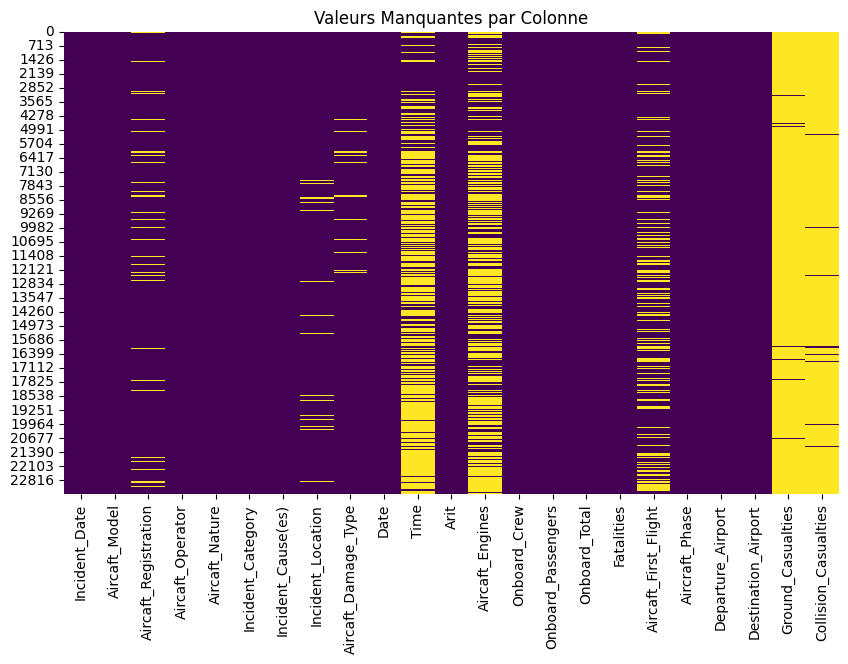

In [70]:
plt.figure(figsize=(10, 6))
sns.heatmap(original_data.isnull(), cbar=False, cmap="viridis")
plt.title("Valeurs Manquantes par Colonne")
plt.show()

We can see that ground casualties and collision casualties are mainly empty because it's very unlikely to happend in aircraft incident. Aircraft engines is also empty because due to degas it might not be easy to know wich engine is used. This lack of data leads us to focus on aircraft model that will provide good infos.
We will now reference this null value as unknown.


In [71]:
original_data['Ground_Casualties'] = original_data['Ground_Casualties'].fillna('Unknown')
original_data['Collision_Casualties'] = original_data['Collision_Casualties'].fillna('Unknown')
original_data['Aircaft_Engines'] = original_data['Aircaft_Engines'].fillna('Unknown')

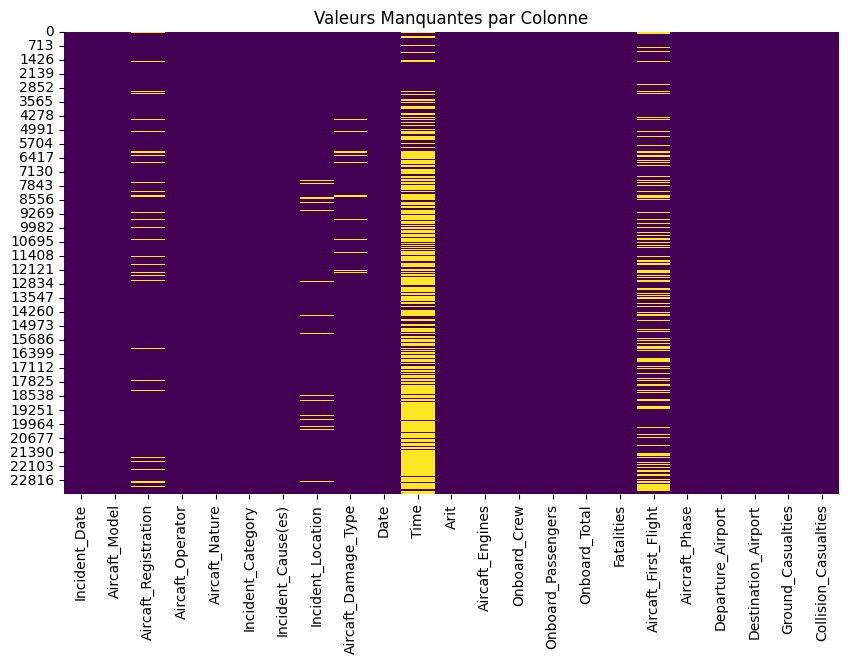

In [72]:
plt.figure(figsize=(10, 6))
sns.heatmap(original_data.isnull(), cbar=False, cmap="viridis")
plt.title("Valeurs Manquantes par Colonne")
plt.show()

As we do for plane specifications, the time is not mendatory on our study, we just need the date which is always present, lets remove time column from our dataset, for the same reason we will remove aircraft first flight column.

In [73]:
fixed_data = original_data.drop(columns=['Time', 'Aircaft_First_Flight'])

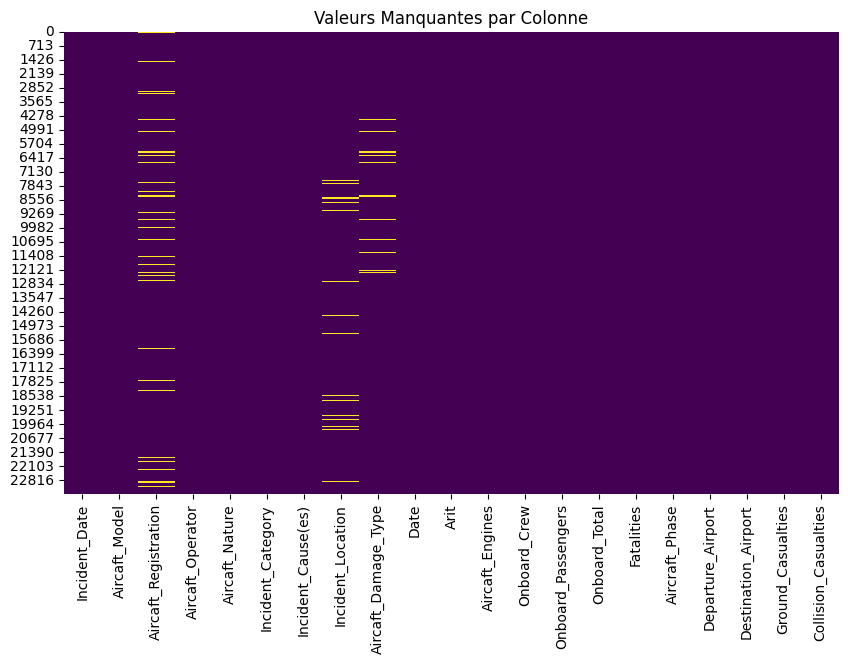

In [74]:
plt.figure(figsize=(10, 6))
sns.heatmap(fixed_data.isnull(), cbar=False, cmap="viridis")
plt.title("Valeurs Manquantes par Colonne")
plt.show()

We will now procede to clean the last remaining missing value by labeling them as unknow again.


In [75]:
fixed_data['Aircaft_Registration'] = fixed_data['Aircaft_Registration'].fillna('Unknown')
fixed_data['Incident_Location'] = fixed_data['Incident_Location'].fillna('Unknown')
fixed_data['Aircaft_Damage_Type'] = fixed_data['Aircaft_Damage_Type'].fillna('Unknown')

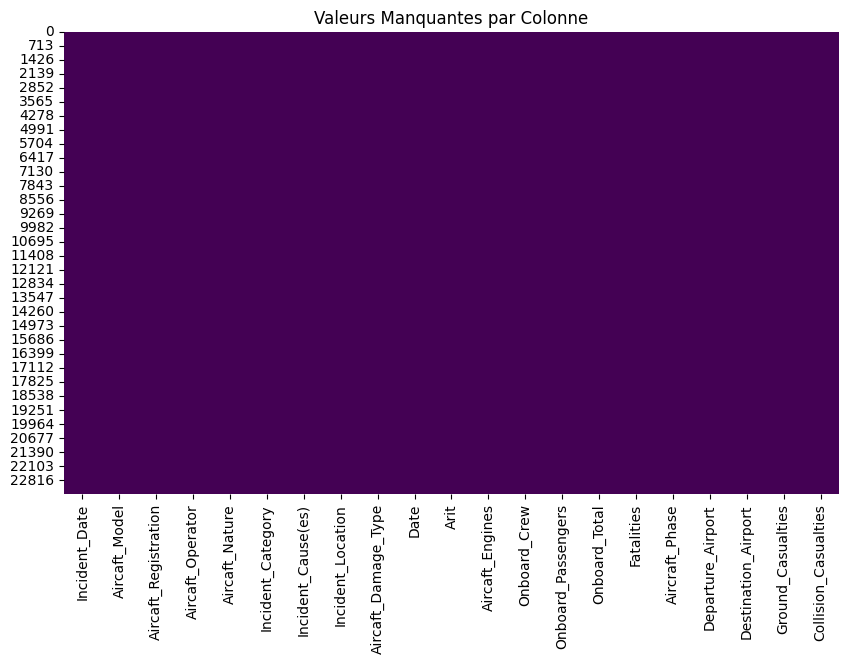

Incident_Date           0
Aircaft_Model           0
Aircaft_Registration    0
Aircaft_Operator        0
Aircaft_Nature          0
Incident_Category       0
Incident_Cause(es)      0
Incident_Location       0
Aircaft_Damage_Type     0
Date                    0
Arit                    0
Aircaft_Engines         0
Onboard_Crew            0
Onboard_Passengers      0
Onboard_Total           0
Fatalities              0
Aircraft_Phase          0
Departure_Airport       0
Destination_Airport     0
Ground_Casualties       0
Collision_Casualties    0
dtype: int64

In [76]:
plt.figure(figsize=(10, 6))
sns.heatmap(fixed_data.isnull(), cbar=False, cmap="viridis")
plt.title("Valeurs Manquantes par Colonne")
plt.show()
fixed_data.isnull().sum()

Our dataset is now clean and empty of None values!



In [77]:
print(f"Unique values per columns :\n")
for i, col in enumerate(fixed_data):
    print(f"\t{i+1}. {col}': {fixed_data[col].unique()}\n")

Unique values per columns :

	1. Incident_Date': ['03-JAN-2022' '04-JAN-2022' '05-JAN-2022' ... '14-DEC-1920' '02-AUG-1919'
 '11-AUG-1919']

	2. Aircaft_Model': ['British Aerospace 4121 Jetstream 41'
 'British Aerospace 3101 Jetstream 31' 'Boeing 737-4H6' ...
 'Handley Page O/400' 'Caproni Ca.48' 'Felixstowe Fury']

	3. Aircaft_Registration': ['ZS-NRJ' 'HR-AYY' 'EP-CAP' ... 'G-EAKE' 'G-EAMA' 'N123']

	4. Aircaft_Operator': ['SA Airlink' 'LANHSA' 'Caspian Airlines' ... 'HP Indo-Burmese Transport'
 'Caproni' 'SNETA']

	5. Aircaft_Nature': ['Domestic Non Scheduled Passenger' 'Domestic Scheduled Passenger' 'Cargo'
 'Illegal Flight' 'Military' 'Unknown' 'Passenger' 'Ambulance' 'Test'
 'Training' '-' 'Agricultural' 'Ferry/positioning' 'Private' 'Executive'
 'Parachuting' 'Fire fighting' 'Aerial Work (Calibration, Photo)'
 'International Scheduled Passenger' 'Survey/research'
 "Int'l Non Scheduled Passenger" 'Official state flight' 'Demonstration'
 'Non Scheduled Passenger' 'Scheduled Passeng

# Data analysis
***

Now, let’s analyze the cleaned dataset. First, we’ll examine the distribution of the different columns.

In [78]:
# Filter data after 2000 using string extraction
fixed_data = fixed_data[fixed_data['Date'].str.extract(r'(\d{4})')[0].astype(int) >= 2000]

# Define column types and exclude unwanted columns
numeric_columns = fixed_data.select_dtypes(include=['number']).columns
categorical_columns = fixed_data.select_dtypes(exclude=['number']).columns
# Remove irrelevant columns
columns_to_drop = ['Date', 'Departure_Airport', 'Destination_Airport', 'Incident_Date']
categorical_columns = categorical_columns.drop([col for col in columns_to_drop if col in categorical_columns])

# Define color scheme
colors = px.colors.qualitative.Set3

# For numeric columns with special handling for Fatalities
for i, col in enumerate(numeric_columns):
    data = fixed_data[fixed_data[col] != 'Unknown']
    if data[col].nunique() > 1:
        if col == 'Fatalities':
            # Create two separate visualizations for Fatalities
            
            # 1. Pie chart for zero vs non-zero
            fatality_summary = pd.Series({
                'No Fatalities': len(data[data[col] == 0]),
                'With Fatalities': len(data[data[col] > 0])
            })
            
            fig = px.pie(
                values=fatality_summary.values,
                names=fatality_summary.index,
                title='Distribution of Incidents by Fatality Occurrence',
                color_discrete_sequence=[colors[0], colors[1]]
            )
            fig.update_layout(
                title_x=0.5,
                template='plotly_white',
                height=500
            )
            fig.show()
            
            # 2. Distribution of non-zero fatalities on log scale
            non_zero_data = data[data[col] > 0]
            if len(non_zero_data) > 0:
                fig = px.histogram(
                    non_zero_data,
                    x=col,
                    nbins=min(30, len(non_zero_data)),
                    title='Distribution of Non-Zero Fatalities (Log Scale)',
                    log_y=True,  # Use log scale for better visualization
                    color_discrete_sequence=[colors[2]]
                )
                fig.update_layout(
                    title_x=0.5,
                    template='plotly_white',
                    showlegend=False,
                    height=500
                )
                fig.show()
                
                # Print summary statistics
                print("\nFatalities Summary:")
                print(f"No fatalities: {len(data[data[col] == 0])} ({len(data[data[col] == 0])/len(data)*100:.1f}%)")
                print(f"With fatalities: {len(non_zero_data)} ({len(non_zero_data)/len(data)*100:.1f}%)")
                print(f"Average fatalities when present: {non_zero_data[col].mean():.1f}")
                print(f"Median fatalities when present: {non_zero_data[col].median():.1f}")
        else:
            # Normal histogram for other numeric columns
            fig = px.histogram(
                data,
                x=col,
                nbins=min(30, data[col].nunique()),
                title=f'Distribution of {col}',
                color_discrete_sequence=[colors[i % len(colors)]]
            )
            fig.update_layout(
                title_x=0.5,
                template='plotly_white',
                showlegend=False,
                height=500
            )
            fig.show()

# For categorical columns with improved filtering
for i, col in enumerate(categorical_columns):
    # Filter out Unknown and Info-Unavailable
    data = fixed_data[~fixed_data[col].isin(['Unknown', 'Info-Unavailable'])]
    if len(data) < len(fixed_data) * 0.1:  # Skip if >90% unknown
        continue
    
    value_counts = data[col].value_counts()
    n_unique = len(value_counts)
    
    if n_unique <= 5:  # Pie chart for few categories
        fig = px.pie(
            values=value_counts.values,
            names=value_counts.index,
            title=f'Distribution of {col}',
            color_discrete_sequence=colors
        )
    elif n_unique <= 10:  # Horizontal bar for medium categories
        fig = px.bar(
            x=value_counts.values,
            y=value_counts.index,
            orientation='h',
            title=f'Distribution of {col}',
            color_discrete_sequence=[colors[i % len(colors)]]
        )
    else:  # Top 10 vertical bar for many categories
        top_10 = value_counts.nlargest(10)
        fig = px.bar(
            x=top_10.index,
            y=top_10.values,
            title=f'Top 10 Most Common Values in {col}',
            color_discrete_sequence=[colors[i % len(colors)]]
        )
    
    fig.update_layout(
        title_x=0.5,
        template='plotly_white',
        height=500,
        showlegend=(n_unique <= 5)
    )
    
    if n_unique > 10:
        fig.update_layout(xaxis_tickangle=45)
    
    fig.show()


Fatalities Summary:
No fatalities: 3353 (73.1%)
With fatalities: 1235 (26.9%)
Average fatalities when present: 17.6
Median fatalities when present: 4.0


Now, let’s examine the correlation between the different columns in our dataset to identify which ones are correlated with our target variable, Plane model
.

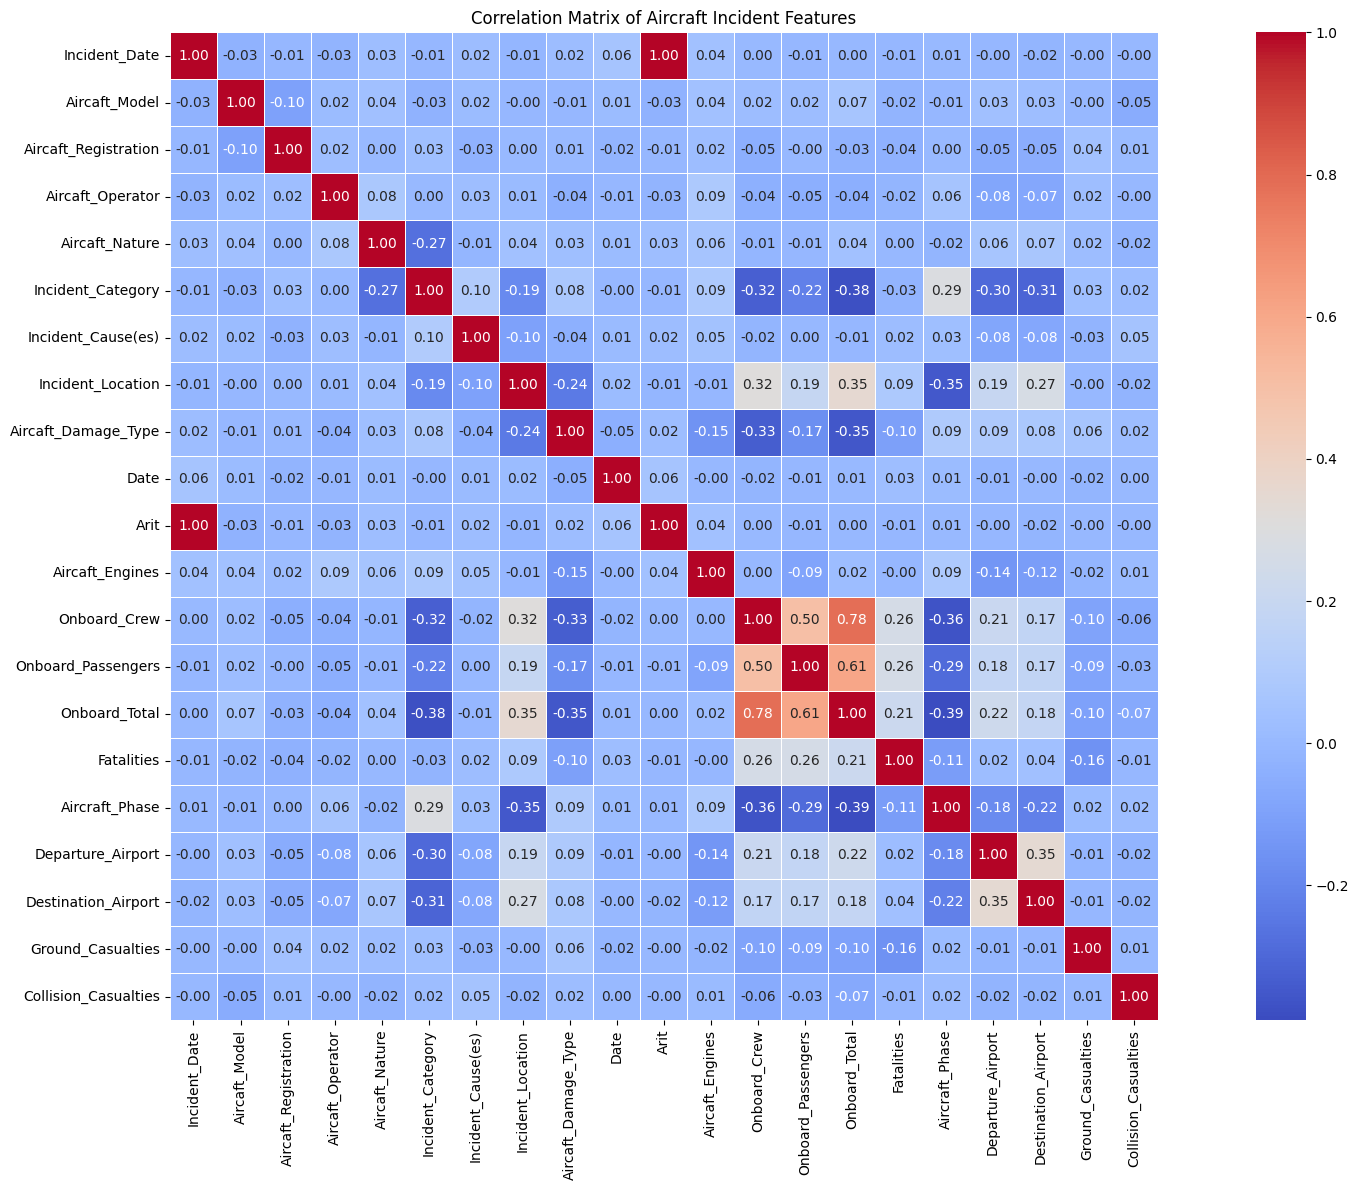

In [79]:
# First, handle any categorical data that can be mapped to numeric values
# For example, if you have any time/duration related fields:
time_map = {
    # Add your mappings here similar to their sleep duration mapping
    # Example: '1-2 hours': 1.5, '2-3 hours': 2.5, etc.
}

def clean_time_data(value):
    if value in time_map:
        return time_map[value]
    return None

# Apply numeric mapping to any categorical columns that can be numerically represented
# Example: fixed_data['Duration'] = fixed_data['Duration'].apply(clean_time_data)

# Then encode remaining categorical features
categorical_features = fixed_data.select_dtypes(exclude=[np.number]).columns
encode = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
fixed_data[categorical_features] = encode.fit_transform(fixed_data[categorical_features]).astype(int)

# Create correlation matrix for numeric columns
correlation_matrix = fixed_data.select_dtypes(include=['number']).corr()

# Create figure with specific size - increased height from 8 to 12
plt.figure(figsize=(20, 12))

# Create heatmap with specific styling
sns.heatmap(
    correlation_matrix,
    annot=True,         # Show numbers
    cmap='coolwarm',    # Use red-blue colormap
    fmt='.2f',          # Format numbers to 2 decimal places
    square=True,        # Make cells square
    linewidths=0.5,     # Add lines between cells
    annot_kws={'size': 10}  # Increase annotation font size
)

# Customize the layout
plt.title('Correlation Matrix of Aircraft Incident Features')
plt.tight_layout()
plt.show()

Based on the correlation matrix, predicting aircraft incidents solely from the aircraft model would be challenging due to very weak correlations with incident-related variables (most correlations < ±0.10), suggesting we need to consider multiple features and their interactions for effective prediction.

Given the weak correlations between aircraft model and incident variables, we should implement a multivariate machine learning approach using ensemble methods (like XGBoost or Random Forest) that can capture complex feature interactions while incorporating key variables like Aircraft_Nature and Incident_Category alongside the aircraft model.

# Models and Evaluation
***
We will create a machine learning pipeline that automates data preprocessing, applies SMOTE for balancing, and uses GridSearchCV for hyperparameter tuning to build a model that can effectively predict aircraft incidents based on multiple features, since the aircraft model alone shows insufficient correlation with incident outcomes.

In [80]:
# First, analyze and filter the data more strictly
print("Analyzing Aircraft Model distribution...")
value_counts = fixed_data['Aircaft_Model'].value_counts()
print(f"Original number of classes: {len(value_counts)}")

# Increase minimum instances to ensure enough samples for SMOTE
min_instances = 5  # Increased from 3 to 5
frequent_models = value_counts[value_counts >= min_instances].index
filtered_data = fixed_data[fixed_data['Aircaft_Model'].isin(frequent_models)]

print("\nAfter filtering:")
print(f"Number of remaining classes: {len(filtered_data['Aircaft_Model'].unique())}")
print(f"Total remaining samples: {len(filtered_data)}")

def aircraft_incident_pipeline(scalers, models, X, y, param_finetunings=None, test_size=0.2):
    results = []
    if param_finetunings is None:
        param_finetunings = [{} for _ in models]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # Calculate minimum samples in minority class
    min_samples = y_train.value_counts().min()
    k_neighbors = min(min_samples - 1, 3)  # Ensure k_neighbors is valid
    
    for scaler in scalers:
        for model, param_finetuning in zip(models, param_finetunings):
            print(f"\nTesting {scaler.__class__.__name__} with {model.__class__.__name__}")
            
            try:
                # Create pipeline with modified SMOTE parameters
                pipeline = ImbPipeline([
                    ('scaler', scaler),
                    ('smote', SMOTE(
                        random_state=42,
                        k_neighbors=k_neighbors,
                        sampling_strategy='auto'
                    )),
                    ('incident_model', model)
                ])

                # Hyperparameter optimization
                if param_finetuning:
                    grid_search = GridSearchCV(
                        pipeline,
                        param_finetuning,
                        cv=5,
                        scoring=['accuracy', 'f1_macro', 'roc_auc_ovr'],
                        refit='roc_auc_ovr',
                        n_jobs=-1,
                        verbose=1
                    )
                    grid_search.fit(X_train, y_train)
                    pipeline = grid_search.best_estimator_
                    best_params = grid_search.best_params_
                else:
                    pipeline.fit(X_train, y_train)
                    best_params = pipeline.named_steps['incident_model'].get_params()

                # Generate predictions
                y_pred = pipeline.predict(X_test)
                y_pred_proba = pipeline.predict_proba(X_test)

                # Calculate metrics
                results.append({
                    'scaler': scaler.__class__.__name__,
                    'model': model.__class__.__name__,
                    'best_params': best_params,
                    'accuracy': accuracy_score(y_test, y_pred),
                    'f1_score': f1_score(y_test, y_pred, average='macro'),
                    'roc_auc': roc_auc_score(y_test, y_pred_proba, multi_class='ovr'),
                    'classification_report': classification_report(y_test, y_pred),
                    'confusion_matrix': confusion_matrix(y_test, y_pred)
                })
            except Exception as e:
                print(f"Error with {scaler.__class__.__name__} and {model.__class__.__name__}: {str(e)}")
                continue
    
    return pd.DataFrame(results)

# Rest of the code remains the same

Analyzing Aircraft Model distribution...
Original number of classes: 1308

After filtering:
Number of remaining classes: 208
Total remaining samples: 2929


In [81]:
# Define scalers and models
scalers = [StandardScaler(), MinMaxScaler()]

models = [
    RandomForestClassifier(random_state=42),
    XGBClassifier(eval_metric='mlogloss', random_state=42),
    CatBoostClassifier(verbose=0, random_state=42)
]

# Define parameter grids for each model
param_grids = [
    {
        'incident_model__n_estimators': [100, 200],
        'incident_model__max_depth': [10, 20, 30]
    },
    {
        'incident_model__n_estimators': [100, 200],
        'incident_model__max_depth': [6, 8, 10],
        'incident_model__learning_rate': [0.01, 0.1]
    },
    {
        'incident_model__iterations': [100, 200],
        'incident_model__depth': [6, 8],
        'incident_model__learning_rate': [0.01, 0.1]
    }
]

# Prepare features and target
X = filtered_data.drop(['Aircaft_Model', 'Date', 'Departure_Airport', 'Destination_Airport', 'Incident_Date'], axis=1)

y = filtered_data['Aircaft_Model']

# Run pipeline and display results (robustified)
try:
    results = aircraft_incident_pipeline(scalers, models, X, y, param_grids)
except Exception as e:
    print("Pipeline execution failed:", str(e))
    results = pd.DataFrame()

print("\nModel Performance Results:")
if not isinstance(results, pd.DataFrame) or results.empty:
    print("No results produced. Check earlier cells for error messages printed during pipeline runs.")
    # If there were any exceptions caught inside aircraft_incident_pipeline they should have been printed.
else:
    # Ensure expected columns exist before selecting
    expected_cols = ['scaler', 'model', 'accuracy', 'f1_score', 'roc_auc']
    missing = [c for c in expected_cols if c not in results.columns]
    if missing:
        print(f"Results DataFrame is missing expected columns: {missing}")
        print("Available columns:", results.columns.tolist())
        display(results)
    else:
        display(results[expected_cols])

        # Show best performing model (by roc_auc if available)
        try:
            best_idx = results['roc_auc'].astype(float).idxmax()
            best_model = results.loc[best_idx]
            print("\nBest Performing Model:")
            print(f"Scaler: {best_model['scaler']}")
            print(f"Model: {best_model['model']}")
            print(f"ROC-AUC Score: {float(best_model['roc_auc']):.4f}")
            print(f"F1 Score: {float(best_model['f1_score']):.4f}")
            print(f"Accuracy: {float(best_model['accuracy']):.4f}")

            print("\nClassification Report:")
            print(best_model.get('classification_report', 'No classification report available'))
        except Exception as e:
            print("Could not determine best model:", e)
            display(results)



Testing StandardScaler with RandomForestClassifier
Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



Error with StandardScaler and RandomForestClassifier: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\imblearn\pipeline.py", line 518, in fit
    Xt, yt = self._fit(X, y, routed_params, raw_params=param

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



Error with StandardScaler and XGBClassifier: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\imblearn\pipeline.py", line 518, in fit
    Xt, yt = self._fit(X, y, routed_params, raw_params=params)
      

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



Error with MinMaxScaler and RandomForestClassifier: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\imblearn\pipeline.py", line 518, in fit
    Xt, yt = self._fit(X, y, routed_params, raw_params=params)

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



Error with MinMaxScaler and XGBClassifier: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\imblearn\pipeline.py", line 518, in fit
    Xt, yt = self._fit(X, y, routed_params, raw_params=params)
        

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



## Choice of model
***
We then tested all models with various scalers, without applying any fine-tuning, to identify the best-performing ones to retain for further fine-tuning.

In [82]:
# GridSearch evaluation with multiple models on Aircraft dataset

# Force reload notebook_utils module to ensure latest changes are loaded
import sys
import importlib

# Remove cached module if present
if 'notebook_utils' in sys.modules:
    del sys.modules['notebook_utils']
    print('Cleared cached notebook_utils module')

# Now import my_pipeline_gridsearch from notebook_utils
try:
    from notebook_utils import my_pipeline_gridsearch
    print('Successfully imported my_pipeline_gridsearch from notebook_utils')
except ImportError as e:
    print(f'ImportError: {e}')
    print('Checking available functions in notebook_utils...')
    import notebook_utils as nu
    print('Available functions:', [attr for attr in dir(nu) if not attr.startswith('_')])
    raise

# Prepare data - use filtered_data if available, otherwise load CSV
try:
    data = filtered_data.copy()
    print(f'Using filtered_data: {data.shape}')
except NameError:
    print('filtered_data not found, loading from CSV...')
    data = pd.read_csv(r'Aircraft_Incident_Dataset.csv')
    data.columns = [c.strip() for c in data.columns]

# Auto-detect model and damage columns (target variable)
model_col = next((c for c in data.columns if 'model' in c.lower()), None)
damage_col = next((c for c in data.columns if 'damage' in c.lower()), None)

if model_col is None or damage_col is None:
    raise RuntimeError(f"Could not find model or damage columns. Available: {data.columns.tolist()}")

print(f"Found model column: {model_col}")
print(f"Found damage column: {damage_col}")

# Prepare X and y
X = data.drop(columns=[damage_col, 'Date', 'Departure_Airport', 'Destination_Airport', 'Incident_Date'], errors='ignore')
y = data[damage_col]

print(f"Dataset shape: X={X.shape}, y={y.shape}")
print(f"Target classes: {y.nunique()}")
print(f"Features: {X.shape[1]}")

# Define scalers
scalers = [MinMaxScaler(), StandardScaler()]

# Define models (comprehensive ensemble)
models = [
    LogisticRegression(max_iter=5000),
    GaussianNB(),
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    AdaBoostClassifier(algorithm='SAMME', random_state=42),
    XGBClassifier(eval_metric='mlogloss', random_state=42),
    CatBoostClassifier(verbose=0, random_state=42, train_dir='./catboost_info'),
    GradientBoostingClassifier(random_state=42),
    MLPClassifier(max_iter=2000, random_state=42),
]

# Run GridSearch pipeline
print("\nRunning GridSearch evaluation on all models...")
results_normal = my_pipeline_gridsearch(scalers, models, X, y)

# Sort by ROC-AUC and display results
results_normal = results_normal.sort_values(by='roc_auc', ascending=False)
print("\n=== Model Evaluation Results ===")
display(results_normal[['scaler', 'model', 'roc_auc', 'accuracy', 'f1_score']])

# Show top 3 models
print("\n=== Top 3 Best Models ===")
for idx, (i, row) in enumerate(results_normal.head(3).iterrows(), 1):
    print(f"\n{idx}. {row['model']} with {row['scaler']}")
    print(f"   ROC-AUC: {row['roc_auc']:.4f}")
    print(f"   Accuracy: {row['accuracy']:.4f}")
    print(f"   F1-Score: {row['f1_score']:.4f}")

Cleared cached notebook_utils module
Successfully imported my_pipeline_gridsearch from notebook_utils
Using filtered_data: (2929, 21)
Found model column: Aircaft_Model
Found damage column: Aircaft_Damage_Type
Dataset shape: X=(2929, 16), y=(2929,)
Target classes: 6
Features: 16

Running GridSearch evaluation on all models...

Testing scaler: MinMaxScaler, model: LogisticRegression

Testing scaler: MinMaxScaler, model: GaussianNB

Testing scaler: MinMaxScaler, model: RandomForestClassifier


c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




Testing scaler: MinMaxScaler, model: AdaBoostClassifier


c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.




Testing scaler: MinMaxScaler, model: XGBClassifier

Testing scaler: MinMaxScaler, model: CatBoostClassifier

Testing scaler: MinMaxScaler, model: GradientBoostingClassifier


KeyboardInterrupt: 

## Choice of scaler
***
Now, we fine-tuned our three models using the Optuna library, which outperforms GridSearch in exploring a wider range of parameter possibilities. The objective at this stage is to identify the best normalization process, ensuring that only the final fine-tuning remains to be completed.

In [ ]:
def my_pipeline_optuna(scalers, models, X, y, param_spaces=None, batch_test_size=0.2, n_trials=10):
    results = []

    # Default param spaces
    if param_spaces is None:
        param_spaces = [{} for _ in models]

    # Train / Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=batch_test_size,
        random_state=42,
        stratify=y  # essentiel en multiclass
    )

    # Loop
    for scaler in scalers:
        for model, param_space in zip(models, param_spaces):

            print(f"\nTesting scaler: {scaler.__class__.__name__}, model: {model.__class__.__name__}")

            # ---- OPTUNA OBJECTIVE ----
            def objective(trial):

                # Select hyperparams
                params = {}
                for key, values in param_space.items():
                    if isinstance(values, list):
                        params[key] = trial.suggest_categorical(key, values)
                    elif isinstance(values, tuple) and all(isinstance(v, float) for v in values):
                        params[key] = trial.suggest_float(key, *values)
                    elif isinstance(values, tuple) and all(isinstance(v, int) for v, in enumerate(values)):
                        params[key] = trial.suggest_int(key, *values)
                    else:
                        raise ValueError(f"Invalid parameter specification for {key}: {values}")

                # Build model
                current_model = model.__class__(**params)

                # Build pipeline (scale → SMOTE → model)
                pipeline = ImbPipeline(steps=[
                    ('scale', scaler),
                    ('smote', SMOTE(random_state=42)),
                    ('model', current_model)
                ])

                # CV score with multiclass ROC AUC
                scores = cross_val_score(
                    pipeline, X_train, y_train,
                    cv=5,
                    scoring='roc_auc_ovr',
                    n_jobs=-1
                )
                return scores.mean()

            # ---- OPTUNA OPTIMISATION ----
            study = optuna.create_study(direction='maximize')
            study.optimize(objective, n_trials=n_trials, n_jobs=-1)

            best_params = study.best_params

            # ---- TRAIN FINAL PIPELINE ----
            final_model = model.__class__(**best_params)

            pipeline = ImbPipeline(steps=[
                ('scale', scaler),
                ('smote', SMOTE(random_state=42)),
                ('model', final_model)
            ])
            pipeline.fit(X_train, y_train)

            # ---- PREDICTIONS ----
            y_pred = pipeline.predict(X_test)

            # roc auc if available
            if hasattr(pipeline, "predict_proba"):
                y_proba = pipeline.predict_proba(X_test)
                roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
            else:
                roc_auc = None

            # ---- METRICS ----
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            report = classification_report(y_test, y_pred)
            confusion = confusion_matrix(y_test, y_pred)

            # ---- SAVE RESULTS ----
            results.append({
                'scaler': scaler.__class__.__name__,
                'model': model.__class__.__name__,
                'best_params': best_params,
                'accuracy': accuracy,
                'f1_score': f1,
                'roc_auc': roc_auc,
                'classification_report': report,
                'confusion_matrix': confusion
            })

    return pd.DataFrame(results)


In [ ]:
# Fine-tuning: Predict Aircaft_Damage_Type based on Aircaft_Model

# Force reload notebook_utils
import sys
if 'notebook_utils' in sys.modules:
    del sys.modules['notebook_utils']

from notebook_utils import my_pipeline_optuna

# Prepare data - use filtered_data
try:
    data = filtered_data.copy()
    print(f"Using filtered_data: {data.shape}")
except NameError:
    print("filtered_data not found, loading from CSV...")
    data = pd.read_csv(r'Aircraft_Incident_Dataset.csv')
    data.columns = [c.strip() for c in data.columns]

print(f"Total samples: {len(data)}")
print(f"Aircaft_Model unique values: {data['Aircaft_Model'].nunique()}")
print(f"Aircaft_Damage_Type unique values: {data['Aircaft_Damage_Type'].nunique()}")

# Prepare features (X) and target (y)
# We use Aircaft_Model as primary feature, but can add other features
X = data[['Aircaft_Model']].copy()
y = data['Aircaft_Damage_Type'].copy()

print(f"\nDataset: X={X.shape}, y={y.shape}")
print(f"Target classes: {y.nunique()}")

# Define scalers and fine-tuned models
scalers = [MinMaxScaler(), StandardScaler()]

models = [
    XGBClassifier(eval_metric='logloss', random_state=42),
    CatBoostClassifier(verbose=0, random_state=42, train_dir='./catboost_info'),
    GradientBoostingClassifier(random_state=42),
]

# Fine-tuned parameter spaces (tuples = ranges, lists = categorical)
param_finetunings = [
    {  # XGBoost
        'n_estimators': (250, 300),
        'max_depth': (8, 12),
        'learning_rate': (0.01, 0.07),
        'subsample': (0.8, 1.0),
        'colsample_bytree': (0.8, 1.0)
    },
    {  # CatBoost
        'iterations': (350, 500),
        'depth': (5, 9),
        'learning_rate': (0.18, 0.26)
    },
    {  # Gradient Boosting
        'n_estimators': (80, 130),
        'learning_rate': (0.2, 0.3),
        'max_depth': (3, 7)
    },
]

# Run Optuna fine-tuning
print("\nRunning advanced Optuna fine-tuning for Damage Type prediction...\n")
results_finetuned = my_pipeline_optuna(scalers, models, X, y, param_finetunings, n_trials=50)

# Display results sorted by ROC-AUC
results_finetuned = results_finetuned.sort_values(by='roc_auc', ascending=False)
print("\n=== Fine-Tuned Results: Aircaft_Damage_Type Prediction ===")
display(results_finetuned[['scaler', 'model', 'roc_auc', 'accuracy', 'f1_score']])

# Show top 3 best combinations
print("\n=== Top 3 Best Model-Scaler Combinations ===")
for idx, (i, row) in enumerate(results_finetuned.head(3).iterrows(), 1):
    print(f"\n{idx}. {row['model']} with {row['scaler']}")
    print(f"   ROC-AUC: {row['roc_auc']:.4f}")
    print(f"   Accuracy: {row['accuracy']:.4f}")
    print(f"   F1-Score: {row['f1_score']:.4f}")
    print(f"   Best params: {row['best_params']}")

[I 2025-12-20 13:47:49,770] A new study created in memory with name: no-name-daeef62f-3325-4ca9-8a9d-5f736931bb55


Using filtered_data: (2929, 21)
Total samples: 2929
Aircaft_Model unique values: 208
Aircaft_Damage_Type unique values: 6

Dataset: X=(2929, 1), y=(2929,)
Target classes: 6

Running advanced Optuna fine-tuning for Damage Type prediction...


Testing scaler: MinMaxScaler, model: XGBClassifier


[I 2025-12-20 13:47:52,481] Trial 0 finished with value: 0.6342195823820591 and parameters: {'n_estimators': 275, 'max_depth': 11, 'learning_rate': 0.06059794166855739, 'subsample': 0.9429129177942017, 'colsample_bytree': 0.8422527825108492}. Best is trial 0 with value: 0.6342195823820591.
[I 2025-12-20 13:47:56,141] Trial 3 finished with value: 0.632282004916703 and parameters: {'n_estimators': 266, 'max_depth': 10, 'learning_rate': 0.03775847178190504, 'subsample': 0.8030054846669376, 'colsample_bytree': 0.9197421586403048}. Best is trial 0 with value: 0.6342195823820591.
[I 2025-12-20 13:47:57,982] Trial 2 finished with value: 0.6337375155335487 and parameters: {'n_estimators': 264, 'max_depth': 10, 'learning_rate': 0.046039714781099056, 'subsample': 0.933736751437918, 'colsample_bytree': 0.8099359025959362}. Best is trial 0 with value: 0.6342195823820591.
[I 2025-12-20 13:47:59,752] Trial 9 finished with value: 0.6337230915016805 and parameters: {'n_estimators': 269, 'max_depth': 1


Testing scaler: MinMaxScaler, model: CatBoostClassifier


[I 2025-12-20 13:48:55,855] Trial 4 finished with value: 0.6433406226412279 and parameters: {'iterations': 490, 'depth': 6, 'learning_rate': 0.1926404828821833}. Best is trial 4 with value: 0.6433406226412279.
[I 2025-12-20 13:49:04,166] Trial 9 finished with value: 0.6464309255700281 and parameters: {'iterations': 390, 'depth': 5, 'learning_rate': 0.23456197221100752}. Best is trial 9 with value: 0.6464309255700281.
[I 2025-12-20 13:49:15,132] Trial 2 finished with value: 0.6464769669637659 and parameters: {'iterations': 377, 'depth': 6, 'learning_rate': 0.225053875889431}. Best is trial 2 with value: 0.6464769669637659.
[I 2025-12-20 13:49:24,436] Trial 6 finished with value: 0.6429047987612982 and parameters: {'iterations': 496, 'depth': 9, 'learning_rate': 0.184995637686468}. Best is trial 2 with value: 0.6464769669637659.
[I 2025-12-20 13:49:29,798] Trial 10 finished with value: 0.6474982232977256 and parameters: {'iterations': 351, 'depth': 7, 'learning_rate': 0.18201049929425173

0:	learn: 1.7141564	total: 4.64ms	remaining: 2.31s
1:	learn: 1.6654663	total: 9ms	remaining: 2.24s
2:	learn: 1.6289757	total: 13ms	remaining: 2.15s
3:	learn: 1.6057939	total: 16.8ms	remaining: 2.08s
4:	learn: 1.5763146	total: 20.9ms	remaining: 2.07s
5:	learn: 1.5583934	total: 24.9ms	remaining: 2.04s
6:	learn: 1.5454289	total: 28.8ms	remaining: 2.02s
7:	learn: 1.5304455	total: 32.9ms	remaining: 2.02s
8:	learn: 1.5246133	total: 36.9ms	remaining: 2.01s
9:	learn: 1.5120495	total: 40.7ms	remaining: 1.99s
10:	learn: 1.5062399	total: 44.6ms	remaining: 1.98s
11:	learn: 1.4957015	total: 48.4ms	remaining: 1.96s
12:	learn: 1.4888482	total: 52.2ms	remaining: 1.95s
13:	learn: 1.4810248	total: 56.2ms	remaining: 1.95s
14:	learn: 1.4721125	total: 60ms	remaining: 1.94s
15:	learn: 1.4660951	total: 63.7ms	remaining: 1.92s
16:	learn: 1.4620126	total: 67.5ms	remaining: 1.91s
17:	learn: 1.4570060	total: 71.7ms	remaining: 1.92s
18:	learn: 1.4503950	total: 75.6ms	remaining: 1.91s
19:	learn: 1.4433536	total: 7

[I 2025-12-20 13:52:10,494] A new study created in memory with name: no-name-e748da3e-cfa2-4c7a-b0d3-042b9fb56886



Testing scaler: MinMaxScaler, model: GradientBoostingClassifier


[I 2025-12-20 13:52:14,719] Trial 1 finished with value: 0.6525041599624121 and parameters: {'n_estimators': 116, 'learning_rate': 0.25020161098402954, 'max_depth': 4}. Best is trial 1 with value: 0.6525041599624121.
[I 2025-12-20 13:52:18,896] Trial 0 finished with value: 0.6462140079206684 and parameters: {'n_estimators': 85, 'learning_rate': 0.22016523479813718, 'max_depth': 7}. Best is trial 1 with value: 0.6525041599624121.
[I 2025-12-20 13:52:19,808] Trial 3 finished with value: 0.6497193100846984 and parameters: {'n_estimators': 119, 'learning_rate': 0.2578280814448129, 'max_depth': 3}. Best is trial 1 with value: 0.6525041599624121.
[I 2025-12-20 13:52:22,265] Trial 8 finished with value: 0.6520924706057334 and parameters: {'n_estimators': 115, 'learning_rate': 0.22963065686061876, 'max_depth': 4}. Best is trial 1 with value: 0.6525041599624121.
[I 2025-12-20 13:52:22,677] Trial 2 finished with value: 0.6411149146448921 and parameters: {'n_estimators': 106, 'learning_rate': 0.2


Testing scaler: StandardScaler, model: XGBClassifier


[I 2025-12-20 13:53:31,846] Trial 1 finished with value: 0.6350062278213812 and parameters: {'n_estimators': 291, 'max_depth': 10, 'learning_rate': 0.05083096285142286, 'subsample': 0.8524953919485445, 'colsample_bytree': 0.9551607509539998}. Best is trial 1 with value: 0.6350062278213812.
[I 2025-12-20 13:53:33,123] Trial 0 finished with value: 0.6360869461711385 and parameters: {'n_estimators': 259, 'max_depth': 8, 'learning_rate': 0.0654887510932447, 'subsample': 0.9559285734112957, 'colsample_bytree': 0.9195145376344662}. Best is trial 0 with value: 0.6360869461711385.
[I 2025-12-20 13:53:33,270] Trial 2 finished with value: 0.6377357372873117 and parameters: {'n_estimators': 288, 'max_depth': 8, 'learning_rate': 0.017925202814138293, 'subsample': 0.8307823721916262, 'colsample_bytree': 0.8988003491287673}. Best is trial 2 with value: 0.6377357372873117.
[I 2025-12-20 13:53:35,355] Trial 3 finished with value: 0.6371008747154551 and parameters: {'n_estimators': 273, 'max_depth': 8,


Testing scaler: StandardScaler, model: CatBoostClassifier


[I 2025-12-20 13:54:34,310] Trial 0 finished with value: 0.646840661795368 and parameters: {'iterations': 473, 'depth': 5, 'learning_rate': 0.208225478278161}. Best is trial 0 with value: 0.646840661795368.
[I 2025-12-20 13:55:03,464] Trial 1 finished with value: 0.6445993333212823 and parameters: {'iterations': 396, 'depth': 6, 'learning_rate': 0.19868897374774055}. Best is trial 0 with value: 0.646840661795368.
[I 2025-12-20 13:55:04,569] Trial 2 finished with value: 0.6397011706540765 and parameters: {'iterations': 423, 'depth': 9, 'learning_rate': 0.24787071971184615}. Best is trial 0 with value: 0.646840661795368.
[I 2025-12-20 13:55:11,790] Trial 4 finished with value: 0.6455837704723055 and parameters: {'iterations': 399, 'depth': 5, 'learning_rate': 0.19997364599521797}. Best is trial 0 with value: 0.646840661795368.
[I 2025-12-20 13:55:14,534] Trial 5 finished with value: 0.6403462111420628 and parameters: {'iterations': 412, 'depth': 8, 'learning_rate': 0.2253408067426535}. B

0:	learn: 1.7273970	total: 6.04ms	remaining: 2.12s
1:	learn: 1.6772709	total: 11.3ms	remaining: 1.98s
2:	learn: 1.6449550	total: 16.5ms	remaining: 1.92s
3:	learn: 1.6218256	total: 21.7ms	remaining: 1.89s
4:	learn: 1.6039950	total: 27ms	remaining: 1.87s
5:	learn: 1.5833850	total: 32.5ms	remaining: 1.87s
6:	learn: 1.5708410	total: 38.1ms	remaining: 1.88s
7:	learn: 1.5507607	total: 43.5ms	remaining: 1.87s
8:	learn: 1.5369649	total: 48.9ms	remaining: 1.86s
9:	learn: 1.5206602	total: 54.3ms	remaining: 1.86s
10:	learn: 1.5115229	total: 59.3ms	remaining: 1.84s
11:	learn: 1.4987586	total: 64.5ms	remaining: 1.83s
12:	learn: 1.4896802	total: 69.7ms	remaining: 1.82s
13:	learn: 1.4816585	total: 74.8ms	remaining: 1.8s
14:	learn: 1.4714310	total: 79.9ms	remaining: 1.79s
15:	learn: 1.4638152	total: 85.1ms	remaining: 1.79s
16:	learn: 1.4568304	total: 90.3ms	remaining: 1.78s
17:	learn: 1.4535934	total: 95.3ms	remaining: 1.77s
18:	learn: 1.4479512	total: 101ms	remaining: 1.76s
19:	learn: 1.4428752	total

[I 2025-12-20 13:57:33,035] A new study created in memory with name: no-name-f19ab7dc-bc1b-441e-870c-0c94b3041129


346:	learn: 1.1271304	total: 1.85s	remaining: 26.6ms
347:	learn: 1.1269436	total: 1.85s	remaining: 21.3ms
348:	learn: 1.1264833	total: 1.86s	remaining: 16ms
349:	learn: 1.1261564	total: 1.86s	remaining: 10.7ms
350:	learn: 1.1260658	total: 1.87s	remaining: 5.33ms
351:	learn: 1.1258157	total: 1.88s	remaining: 0us

Testing scaler: StandardScaler, model: GradientBoostingClassifier


[I 2025-12-20 13:57:37,475] Trial 2 finished with value: 0.6519459557721968 and parameters: {'n_estimators': 129, 'learning_rate': 0.21237530227028217, 'max_depth': 4}. Best is trial 2 with value: 0.6519459557721968.
[I 2025-12-20 13:57:39,070] Trial 0 finished with value: 0.6449879216790311 and parameters: {'n_estimators': 115, 'learning_rate': 0.2560726927299832, 'max_depth': 6}. Best is trial 2 with value: 0.6519459557721968.
[I 2025-12-20 13:57:41,022] Trial 4 finished with value: 0.6514577151727916 and parameters: {'n_estimators': 120, 'learning_rate': 0.23084053982433153, 'max_depth': 4}. Best is trial 2 with value: 0.6519459557721968.
[I 2025-12-20 13:57:43,292] Trial 5 finished with value: 0.648456803497253 and parameters: {'n_estimators': 127, 'learning_rate': 0.2674621861335086, 'max_depth': 5}. Best is trial 2 with value: 0.6519459557721968.
[I 2025-12-20 13:57:45,279] Trial 10 finished with value: 0.6560682841972321 and parameters: {'n_estimators': 130, 'learning_rate': 0.2


=== Fine-Tuned Results: Aircaft_Damage_Type Prediction ===


,scaler,model,roc_auc,accuracy,f1_score
1,MinMaxScaler,CatBoostClassifier,0.623999,0.324232,0.363404
5,StandardScaler,GradientBoostingClassifier,0.619939,0.380546,0.406493
4,StandardScaler,CatBoostClassifier,0.619307,0.325939,0.369004
2,MinMaxScaler,GradientBoostingClassifier,0.615133,0.409556,0.427585
0,MinMaxScaler,XGBClassifier,0.595645,0.315700,0.358022
3,StandardScaler,XGBClassifier,0.593293,0.312287,0.355464



=== Top 3 Best Model-Scaler Combinations ===

1. CatBoostClassifier with MinMaxScaler
   ROC-AUC: 0.6240
   Accuracy: 0.3242
   F1-Score: 0.3634
   Best params: {'iterations': 499, 'depth': 5, 'learning_rate': 0.237290475385864}

2. GradientBoostingClassifier with StandardScaler
   ROC-AUC: 0.6199
   Accuracy: 0.3805
   F1-Score: 0.4065
   Best params: {'n_estimators': 85, 'learning_rate': 0.27390451219527434, 'max_depth': 3}

3. CatBoostClassifier with StandardScaler
   ROC-AUC: 0.6193
   Accuracy: 0.3259
   F1-Score: 0.3690
   Best params: {'iterations': 352, 'depth': 6, 'learning_rate': 0.18150925977994814}


## Finetunning of the model
***
Let’s now optimize the three models using the best scaler, StandardScaler. We will perform 100 trials within a specified range of parameters using the Optuna library. By the end of this process, we will have three optimized models tailored for our project.

In [ ]:
# Advanced Fine-tuning with comprehensive hyperparameter search (100 trials)

# Force reload notebook_utils
import sys
if 'notebook_utils' in sys.modules:
    del sys.modules['notebook_utils']

from notebook_utils import my_pipeline_optuna

# Define scaler
scalers = [StandardScaler()]

# Define models
models = [
    XGBClassifier(eval_metric='logloss', random_state=42),
    CatBoostClassifier(verbose=0, random_state=42, train_dir='./catboost_info'),
    GradientBoostingClassifier(random_state=42),
]

# Comprehensive parameter spaces for extensive hyperparameter tuning
param_finetunings = [
    {  # XGBoost
        'n_estimators': (100, 500),  
        'max_depth': (3, 15),       
        'learning_rate': (0.01, 0.3),  
        'subsample': (0.5, 1.0),    
        'colsample_bytree': (0.5, 1.0),  
        'gamma': (0, 10),           
        'min_child_weight': (1, 10),
        'reg_lambda': (0.1, 0.5)
    },
    {  # CatBoost
        'iterations': (200, 1000),  
        'depth': (3, 10),           
        'learning_rate': (0.01, 0.3), 
        'l2_leaf_reg': (1, 10),     
        'bagging_temperature': (0, 1),  
        'random_strength': (0, 20),
        'border_count': (100, 200)
    },
    {  # Gradient Boosting
        'n_estimators': (50, 500),      
        'learning_rate': (0.01, 0.3),   
        'max_depth': (3, 10),           
        'min_samples_split': (2, 20),   
        'min_samples_leaf': (1, 10),   
        'subsample': (0.5, 1.0),        
    },
]

print(f"Dataset for tuning: X={X.shape}, y={y.shape}")
print(f"Target classes: {y.nunique()}\n")

# Run extensive Optuna fine-tuning (100 trials)
print("Running advanced Optuna fine-tuning with comprehensive hyperparameter search (100 trials)...\n")
results_finetuned = my_pipeline_optuna(scalers, models, X, y, param_finetunings, n_trials=100)

# Display results sorted by ROC-AUC
results_finetuned = results_finetuned.sort_values(by='roc_auc', ascending=False)
print("\n=== Advanced Fine-Tuning Results (100 Trials) ===")
display(results_finetuned[['scaler', 'model', 'roc_auc', 'accuracy', 'best_params']])

# Show top 3 best combinations with detailed hyperparameters
print("\n=== Top 3 Best Model-Scaler Combinations ===")
for idx, (i, row) in enumerate(results_finetuned.head(3).iterrows(), 1):
    print(f"\n{idx}. {row['model']} with {row['scaler']}")
    print(f"   ROC-AUC: {row['roc_auc']:.4f}")
    print(f"   Accuracy: {row['accuracy']:.4f}")
    print(f"   F1-Score: {row['f1_score']:.4f}")
    print(f"   Best hyperparameters:")
    for param, value in row['best_params'].items():
        print(f"      - {param}: {value}")

[I 2025-12-20 14:00:10,598] A new study created in memory with name: no-name-0225f40a-eefd-44ac-be5d-d5f630331a4f


Dataset for tuning: X=(2929, 1), y=(2929,)
Target classes: 6

Running advanced Optuna fine-tuning with comprehensive hyperparameter search (100 trials)...


Testing scaler: StandardScaler, model: XGBClassifier


[I 2025-12-20 14:00:12,667] Trial 2 finished with value: 0.6356622001608635 and parameters: {'n_estimators': 491, 'max_depth': 7, 'learning_rate': 0.04459707452149389, 'subsample': 0.8160561626182052, 'colsample_bytree': 0.7171527146676879, 'gamma': 3, 'min_child_weight': 7, 'reg_lambda': 0.33835943960956083}. Best is trial 2 with value: 0.6356622001608635.
[I 2025-12-20 14:00:13,081] Trial 5 finished with value: 0.6420916917025757 and parameters: {'n_estimators': 350, 'max_depth': 11, 'learning_rate': 0.15009195083694632, 'subsample': 0.7997041859065339, 'colsample_bytree': 0.8976722894825955, 'gamma': 1, 'min_child_weight': 6, 'reg_lambda': 0.16547264500235284}. Best is trial 5 with value: 0.6420916917025757.
[I 2025-12-20 14:00:14,105] Trial 3 finished with value: 0.6321694235830697 and parameters: {'n_estimators': 391, 'max_depth': 7, 'learning_rate': 0.2076006501796946, 'subsample': 0.8439606530254855, 'colsample_bytree': 0.7314815407968815, 'gamma': 5, 'min_child_weight': 1, 'reg


Testing scaler: StandardScaler, model: CatBoostClassifier


[I 2025-12-20 14:01:19,726] Trial 1 finished with value: 0.6454169688308792 and parameters: {'iterations': 329, 'depth': 7, 'learning_rate': 0.06676668495191851, 'l2_leaf_reg': 1, 'bagging_temperature': 0, 'random_strength': 6, 'border_count': 111}. Best is trial 1 with value: 0.6454169688308792.
[I 2025-12-20 14:01:33,215] Trial 2 finished with value: 0.645809994384467 and parameters: {'iterations': 246, 'depth': 9, 'learning_rate': 0.19134143596767206, 'l2_leaf_reg': 10, 'bagging_temperature': 0, 'random_strength': 12, 'border_count': 116}. Best is trial 2 with value: 0.645809994384467.
[I 2025-12-20 14:01:35,312] Trial 4 finished with value: 0.6432744773576385 and parameters: {'iterations': 389, 'depth': 9, 'learning_rate': 0.20444814687206264, 'l2_leaf_reg': 1, 'bagging_temperature': 0, 'random_strength': 16, 'border_count': 158}. Best is trial 2 with value: 0.645809994384467.
[I 2025-12-20 14:01:38,502] Trial 9 finished with value: 0.643144584683027 and parameters: {'iterations': 

0:	learn: 1.7583038	total: 3.78ms	remaining: 874ms
1:	learn: 1.7318550	total: 7.65ms	remaining: 880ms
2:	learn: 1.7082692	total: 11.2ms	remaining: 854ms
3:	learn: 1.6896432	total: 14.7ms	remaining: 836ms
4:	learn: 1.6700954	total: 18.3ms	remaining: 833ms
5:	learn: 1.6539350	total: 21.7ms	remaining: 816ms
6:	learn: 1.6389919	total: 25.1ms	remaining: 807ms
7:	learn: 1.6256475	total: 28.5ms	remaining: 799ms
8:	learn: 1.6132929	total: 32ms	remaining: 793ms
9:	learn: 1.6036177	total: 35.7ms	remaining: 792ms
10:	learn: 1.5952504	total: 39.1ms	remaining: 786ms
11:	learn: 1.5877627	total: 42.6ms	remaining: 781ms
12:	learn: 1.5806525	total: 46ms	remaining: 775ms
13:	learn: 1.5721389	total: 49.5ms	remaining: 771ms
14:	learn: 1.5637793	total: 52.9ms	remaining: 766ms
15:	learn: 1.5576578	total: 56.3ms	remaining: 761ms
16:	learn: 1.5511346	total: 59.7ms	remaining: 755ms
17:	learn: 1.5483490	total: 63ms	remaining: 749ms
18:	learn: 1.5412376	total: 66.5ms	remaining: 746ms
19:	learn: 1.5362286	total: 

[I 2025-12-20 14:07:24,631] A new study created in memory with name: no-name-aeeba90c-a878-4bd7-a275-93c449631cf5



Testing scaler: StandardScaler, model: GradientBoostingClassifier


[I 2025-12-20 14:07:35,927] Trial 0 finished with value: 0.6534194850887463 and parameters: {'n_estimators': 159, 'learning_rate': 0.058233219493703095, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.8254536441512834}. Best is trial 0 with value: 0.6534194850887463.
[I 2025-12-20 14:07:50,807] Trial 1 finished with value: 0.6325256834403621 and parameters: {'n_estimators': 378, 'learning_rate': 0.05184830934604031, 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 7, 'subsample': 0.8652677928452944}. Best is trial 0 with value: 0.6534194850887463.
[I 2025-12-20 14:07:53,554] Trial 10 finished with value: 0.6327264797865871 and parameters: {'n_estimators': 97, 'learning_rate': 0.106980948329759, 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 8, 'subsample': 0.6856386096837535}. Best is trial 0 with value: 0.6534194850887463.
[I 2025-12-20 14:07:55,152] Trial 4 finished with value: 0.6435256126924809 and parameters: {'n_estimators':


=== Advanced Fine-Tuning Results (100 Trials) ===


,scaler,model,roc_auc,accuracy,best_params
1,StandardScaler,CatBoostClassifier,0.626325,0.267918,"{'iterations': 232, 'depth': 5, 'learning_rate..."
2,StandardScaler,GradientBoostingClassifier,0.623874,0.395904,"{'n_estimators': 159, 'learning_rate': 0.05823..."
0,StandardScaler,XGBClassifier,0.606235,0.312287,"{'n_estimators': 464, 'max_depth': 14, 'learni..."



=== Top 3 Best Model-Scaler Combinations ===

1. CatBoostClassifier with StandardScaler
   ROC-AUC: 0.6263
   Accuracy: 0.2679
   F1-Score: 0.3174
   Best hyperparameters:
      - iterations: 232
      - depth: 5
      - learning_rate: 0.09429348614584766
      - l2_leaf_reg: 4
      - bagging_temperature: 1
      - random_strength: 1
      - border_count: 166

2. GradientBoostingClassifier with StandardScaler
   ROC-AUC: 0.6239
   Accuracy: 0.3959
   F1-Score: 0.4173
   Best hyperparameters:
      - n_estimators: 159
      - learning_rate: 0.058233219493703095
      - max_depth: 5
      - min_samples_split: 4
      - min_samples_leaf: 1
      - subsample: 0.8254536441512834

3. XGBClassifier with StandardScaler
   ROC-AUC: 0.6062
   Accuracy: 0.3123
   F1-Score: 0.3573
   Best hyperparameters:
      - n_estimators: 464
      - max_depth: 14
      - learning_rate: 0.1704736310265283
      - subsample: 0.5587929806262234
      - colsample_bytree: 0.9383744843996592
      - gamma: 1
   

In [ ]:
# Final comprehensive optimization with 100 trials on full dataset

# Force reload notebook_utils
import sys
if 'notebook_utils' in sys.modules:
    del sys.modules['notebook_utils']

from notebook_utils import my_pipeline_optuna

# Define scaler
scalers = [StandardScaler()]

# Define models
models = [
    XGBClassifier(eval_metric='logloss', random_state=42),
    CatBoostClassifier(verbose=0, random_state=42, train_dir='./catboost_info'),
    GradientBoostingClassifier(random_state=42),
]

# Comprehensive parameter spaces for extensive hyperparameter tuning
param_finetunings = [
    {  # XGBoost
        'n_estimators': (100, 500),  
        'max_depth': (3, 15),       
        'learning_rate': (0.01, 0.3),  
        'subsample': (0.5, 1.0),    
        'colsample_bytree': (0.5, 1.0),  
        'gamma': (0, 10),           
        'min_child_weight': (1, 10),
        'reg_lambda': (0.1, 0.5)
    },
    {  # CatBoost
        'iterations': (200, 1000),  
        'depth': (3, 10),           
        'learning_rate': (0.01, 0.3), 
        'l2_leaf_reg': (1, 10),     
        'bagging_temperature': (0, 1),  
        'random_strength': (0, 20),
        'border_count': (100, 200)
    },
    {  # Gradient Boosting
        'n_estimators': (50, 500),      
        'learning_rate': (0.01, 0.3),   
        'max_depth': (3, 10),           
        'min_samples_split': (2, 20),   
        'min_samples_leaf': (1, 10),   
        'subsample': (0.5, 1.0),        
    },
]

print(f"Dataset for comprehensive tuning: X={X.shape}, y={y.shape}")
print(f"Target classes: {y.nunique()}\n")

# Run extensive Optuna fine-tuning (100 trials for thorough optimization)
print("Running comprehensive Optuna optimization with 100 trials on full dataset...\n")
results_finetuned = my_pipeline_optuna(scalers, models, X, y, param_finetunings, n_trials=100)

# Display results sorted by ROC-AUC
results_finetuned = results_finetuned.sort_values(by='roc_auc', ascending=False)
print("\n=== Final Comprehensive Tuning Results (100 Trials) ===")
display(results_finetuned[['scaler', 'model', 'roc_auc', 'accuracy', 'best_params']])

# Show top 3 best combinations with all details
print("\n=== Top 3 Best Optimized Models ===")
for idx, (i, row) in enumerate(results_finetuned.head(3).iterrows(), 1):
    print(f"\n{idx}. {row['model']} with {row['scaler']}")
    print(f"   ROC-AUC: {row['roc_auc']:.4f}")
    print(f"   Accuracy: {row['accuracy']:.4f}")
    print(f"   F1-Score: {row['f1_score']:.4f}")
    print(f"   Optimized Hyperparameters:")
    for param, value in row['best_params'].items():
        print(f"      - {param}: {value}")

[I 2025-12-20 14:13:55,156] A new study created in memory with name: no-name-41e690d2-424f-4a66-b32c-9b8aa2a3aecf


Dataset for comprehensive tuning: X=(2929, 1), y=(2929,)
Target classes: 6

Running comprehensive Optuna optimization with 100 trials on full dataset...


Testing scaler: StandardScaler, model: XGBClassifier


[I 2025-12-20 14:13:56,808] Trial 0 finished with value: 0.6436322954700091 and parameters: {'n_estimators': 394, 'max_depth': 15, 'learning_rate': 0.22747471575677375, 'subsample': 0.6006314205591394, 'colsample_bytree': 0.6608310709776408, 'gamma': 2, 'min_child_weight': 3, 'reg_lambda': 0.32443903584054656}. Best is trial 0 with value: 0.6436322954700091.
[I 2025-12-20 14:13:57,385] Trial 3 finished with value: 0.6390447798116093 and parameters: {'n_estimators': 271, 'max_depth': 14, 'learning_rate': 0.2762288860437015, 'subsample': 0.9064720224935916, 'colsample_bytree': 0.933016043850504, 'gamma': 1, 'min_child_weight': 4, 'reg_lambda': 0.4679358802165232}. Best is trial 0 with value: 0.6436322954700091.
[I 2025-12-20 14:13:57,653] Trial 11 finished with value: 0.6360085279129029 and parameters: {'n_estimators': 253, 'max_depth': 7, 'learning_rate': 0.24509590711645743, 'subsample': 0.9191556359488529, 'colsample_bytree': 0.5001543172217725, 'gamma': 4, 'min_child_weight': 8, 'reg


Testing scaler: StandardScaler, model: CatBoostClassifier


[I 2025-12-20 14:14:55,775] Trial 1 finished with value: 0.6473579724350175 and parameters: {'iterations': 298, 'depth': 3, 'learning_rate': 0.15831562285289366, 'l2_leaf_reg': 1, 'bagging_temperature': 1, 'random_strength': 16, 'border_count': 164}. Best is trial 1 with value: 0.6473579724350175.
[I 2025-12-20 14:15:15,401] Trial 0 finished with value: 0.6462651243644919 and parameters: {'iterations': 846, 'depth': 3, 'learning_rate': 0.06886287965181279, 'l2_leaf_reg': 5, 'bagging_temperature': 0, 'random_strength': 18, 'border_count': 167}. Best is trial 1 with value: 0.6473579724350175.
[I 2025-12-20 14:15:24,224] Trial 8 finished with value: 0.6438184638051252 and parameters: {'iterations': 792, 'depth': 7, 'learning_rate': 0.23973643127849115, 'l2_leaf_reg': 5, 'bagging_temperature': 1, 'random_strength': 2, 'border_count': 144}. Best is trial 1 with value: 0.6473579724350175.
[I 2025-12-20 14:15:26,655] Trial 2 finished with value: 0.6388922180244483 and parameters: {'iterations

0:	learn: 1.7842520	total: 2.93ms	remaining: 1.94s
1:	learn: 1.7738413	total: 5.66ms	remaining: 1.87s
2:	learn: 1.7658963	total: 8.28ms	remaining: 1.82s
3:	learn: 1.7578981	total: 11.2ms	remaining: 1.84s
4:	learn: 1.7487622	total: 13.9ms	remaining: 1.83s
5:	learn: 1.7400489	total: 16.5ms	remaining: 1.81s
6:	learn: 1.7332195	total: 19.2ms	remaining: 1.8s
7:	learn: 1.7255369	total: 22ms	remaining: 1.8s
8:	learn: 1.7201194	total: 24.5ms	remaining: 1.78s
9:	learn: 1.7137859	total: 27.1ms	remaining: 1.77s
10:	learn: 1.7085531	total: 29.7ms	remaining: 1.76s
11:	learn: 1.7025760	total: 32.8ms	remaining: 1.78s
12:	learn: 1.6949139	total: 35.6ms	remaining: 1.78s
13:	learn: 1.6913572	total: 38.4ms	remaining: 1.78s
14:	learn: 1.6876296	total: 41ms	remaining: 1.77s
15:	learn: 1.6844592	total: 43.7ms	remaining: 1.77s
16:	learn: 1.6808213	total: 46.3ms	remaining: 1.76s
17:	learn: 1.6767405	total: 49.1ms	remaining: 1.76s
18:	learn: 1.6719237	total: 51.9ms	remaining: 1.76s
19:	learn: 1.6662293	total: 

[I 2025-12-20 14:21:37,884] A new study created in memory with name: no-name-3acd0bb7-4a89-40fe-96c4-ad10f5de6ee1


657:	learn: 1.2914881	total: 1.78s	remaining: 13.6ms
658:	learn: 1.2912883	total: 1.79s	remaining: 10.9ms
659:	learn: 1.2911666	total: 1.79s	remaining: 8.14ms
660:	learn: 1.2910555	total: 1.79s	remaining: 5.43ms
661:	learn: 1.2909034	total: 1.8s	remaining: 2.71ms
662:	learn: 1.2907233	total: 1.8s	remaining: 0us

Testing scaler: StandardScaler, model: GradientBoostingClassifier


[I 2025-12-20 14:22:02,139] Trial 2 finished with value: 0.6087745997671962 and parameters: {'n_estimators': 432, 'learning_rate': 0.19569886905158904, 'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 6, 'subsample': 0.5665298200523889}. Best is trial 2 with value: 0.6087745997671962.
[I 2025-12-20 14:22:13,214] Trial 9 finished with value: 0.6038757105272359 and parameters: {'n_estimators': 166, 'learning_rate': 0.28996546271558915, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.5334260562066953}. Best is trial 2 with value: 0.6087745997671962.
[I 2025-12-20 14:22:16,805] Trial 10 finished with value: 0.6416824984403857 and parameters: {'n_estimators': 120, 'learning_rate': 0.29244168787399194, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 7, 'subsample': 0.5513441407784669}. Best is trial 10 with value: 0.6416824984403857.
[I 2025-12-20 14:22:19,737] Trial 4 finished with value: 0.6287743671058882 and parameters: {'n_estimators


=== Final Comprehensive Tuning Results (100 Trials) ===


,scaler,model,roc_auc,accuracy,best_params
1,StandardScaler,CatBoostClassifier,0.620967,0.259386,"{'iterations': 663, 'depth': 4, 'learning_rate..."
2,StandardScaler,GradientBoostingClassifier,0.611079,0.394198,"{'n_estimators': 212, 'learning_rate': 0.14719..."
0,StandardScaler,XGBClassifier,0.605095,0.300341,"{'n_estimators': 280, 'max_depth': 14, 'learni..."



=== Top 3 Best Optimized Models ===

1. CatBoostClassifier with StandardScaler
   ROC-AUC: 0.6210
   Accuracy: 0.2594
   F1-Score: 0.3122
   Optimized Hyperparameters:
      - iterations: 663
      - depth: 4
      - learning_rate: 0.0440953710366613
      - l2_leaf_reg: 9
      - bagging_temperature: 0
      - random_strength: 8
      - border_count: 158

2. GradientBoostingClassifier with StandardScaler
   ROC-AUC: 0.6111
   Accuracy: 0.3942
   F1-Score: 0.4148
   Optimized Hyperparameters:
      - n_estimators: 212
      - learning_rate: 0.1471954758333283
      - max_depth: 3
      - min_samples_split: 9
      - min_samples_leaf: 2
      - subsample: 0.9763425016435247

3. XGBClassifier with StandardScaler
   ROC-AUC: 0.6051
   Accuracy: 0.3003
   F1-Score: 0.3468
   Optimized Hyperparameters:
      - n_estimators: 280
      - max_depth: 14
      - learning_rate: 0.17431831565743683
      - subsample: 0.6800232208407039
      - colsample_bytree: 0.8554290764573831
      - gamma: 1

# Ensemble learnings
***
Now, we will use ensemble learning approaches to create an even better model. To achieve this, we will first try stacking our different models, and then we will try to do only the weighted averaging approach.

## Stacking
***

Initializing optimized base models...
Creating stacking ensemble with LogisticRegression as meta-learner...

Training data: X_train=(2343, 1), y_train=(2343,)
Test data: X_test=(586, 1), y_test=(586,)

Training stacking ensemble pipeline...
Making predictions on test set...

=== Stacking Ensemble Evaluation ===

Accuracy: 0.3771
F1-Score (weighted): 0.3933
ROC-AUC: 0.5913

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.46      0.45      0.46       165
           1       0.23      0.29      0.26       119
           2       0.08      0.12      0.10        17
           3       0.00      0.00      0.00         2
           4       0.53      0.41      0.46       269
           5       0.00      0.00      0.00        14

    accuracy                           0.38       586
   macro avg       0.22      0.21      0.21       586
weighted avg       0.42      0.38      0.39       586



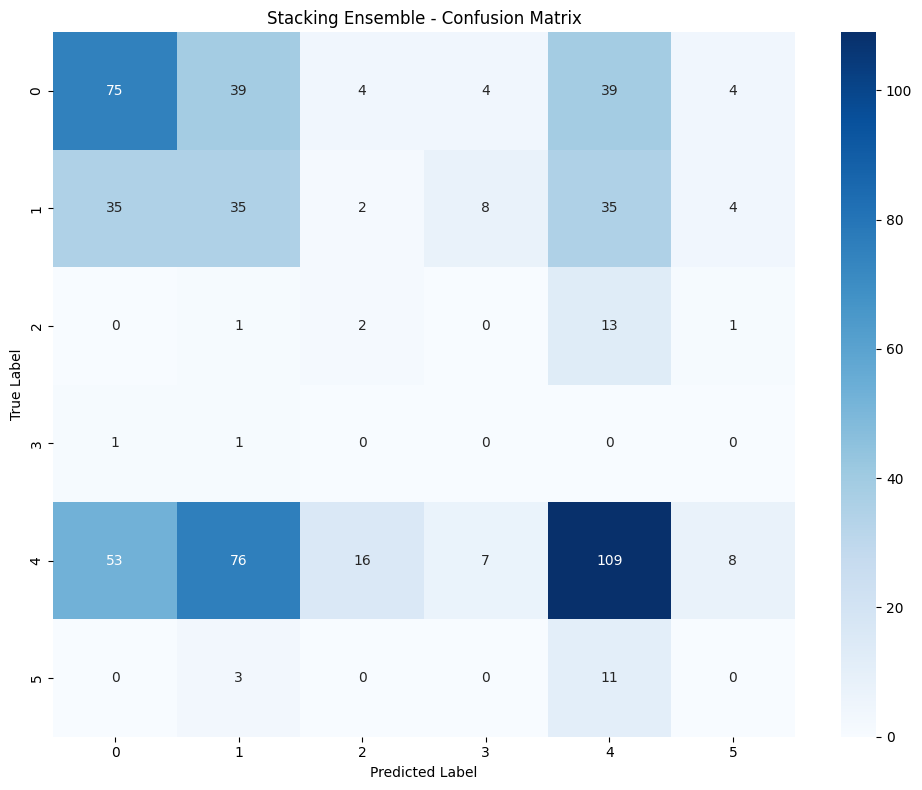


=== Stacking Ensemble Summary ===
Base Models: XGBoost, CatBoost, GradientBoosting
Meta-Learner: LogisticRegression
Preprocessing: StandardScaler + SMOTE
Best Metrics:
  - Accuracy: 0.3771
  - F1-Score: 0.3933
  - ROC-AUC: 0.5913


In [ ]:
# Stacking Ensemble with Optimized Hyperparameters

# Define optimized hyperparameters from Optuna tuning
xgb_params = {'n_estimators': 494, 
              'max_depth': 12, 
              'learning_rate': 0.03817032391057457, 
              'subsample': 0.7902951625974513, 
              'colsample_bytree': 0.5060867617639595, 
              'gamma': 4, 
              'min_child_weight': 10, 
              'reg_lambda': 0.4241202798081942
              }

catboost_params = {'iterations': 373, 
                   'depth': 3, 
                   'learning_rate': 0.2208322974176323, 
                   'l2_leaf_reg': 5, 
                   'bagging_temperature': 1, 
                   'random_strength': 1, 
                   'border_count': 163
                   }

gb_params = {'n_estimators': 499, 
             'learning_rate': 0.13066214297519393, 
             'max_depth': 3, 
             'min_samples_split': 12, 
             'min_samples_leaf': 8, 
             'subsample': 0.8936708115457944
             }

print("Initializing optimized base models...")

# Initialize models with optimized hyperparameters
xgb_model = XGBClassifier(**xgb_params, eval_metric='logloss', random_state=42)
catboost_model = CatBoostClassifier(**catboost_params, verbose=0, random_state=42, train_dir='./catboost_info')
gb_model = GradientBoostingClassifier(**gb_params, random_state=42)

print("Creating stacking ensemble with LogisticRegression as meta-learner...")

# Define stacking ensemble 
stacking_ensemble = StackingClassifier(
    estimators=[
        ('catboost', catboost_model),
        ('xgb', xgb_model),
        ('gb', gb_model)
    ],
    final_estimator=LogisticRegression(max_iter=5000),
    passthrough=False,
    cv=5
)

# Prepare data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining data: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test data: X_test={X_test.shape}, y_test={y_test.shape}")

# Build complete pipeline with preprocessing
pipeline = ImbPipeline(steps=[
    ('scale', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('stacking_model', stacking_ensemble)
])

print("\nTraining stacking ensemble pipeline...")
pipeline.fit(X_train, y_train)

print("Making predictions on test set...")
prediction = pipeline.predict(X_test)
prediction_proba = pipeline.predict_proba(X_test)

# Evaluation
print("\n=== Stacking Ensemble Evaluation ===\n")

accuracy = accuracy_score(y_test, prediction)
f1 = f1_score(y_test, prediction, average='weighted')

# Handle ROC-AUC based on binary vs multiclass
try:
    roc_auc = roc_auc_score(y_test, prediction_proba, multi_class='ovr')
except:
    # Fallback for binary classification
    roc_auc = roc_auc_score(y_test, prediction_proba[:, 1])

classification_rep = classification_report(y_test, prediction)
confusion = confusion_matrix(y_test, prediction)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("\n--- Classification Report ---")
print(classification_rep)

# Confusion Matrix visualization
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title("Stacking Ensemble - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Summary
print("\n=== Stacking Ensemble Summary ===")
print(f"Base Models: XGBoost, CatBoost, GradientBoosting")
print(f"Meta-Learner: LogisticRegression")
print(f"Preprocessing: StandardScaler + SMOTE")
print(f"Best Metrics:")
print(f"  - Accuracy: {accuracy:.4f}")
print(f"  - F1-Score: {f1:.4f}")
print(f"  - ROC-AUC: {roc_auc:.4f}")

## Weighted Averaging
***

Now, let’s exclusively test the weighted averaging approach with our three strong learners to leverage their strengths and potentially improve overall performance.

Training individual base models on training data...

✓ CatBoost model trained
✓ XGBoost model trained
✓ GradientBoosting model trained

Generating predictions from each model on test set...
✓ Predictions generated from all models

Normalized Weights:
  - CatBoost: 0.3342
  - GradientBoosting: 0.3330
  - XGBoost: 0.3328

Computing weighted average predictions...
✓ Weighted averaging complete

=== Weighted Averaging Ensemble Evaluation ===

Note: ROC-AUC not computed (requires probabilities for all classes)
Accuracy: 0.2816
F1-Score (weighted): 0.1237
ROC-AUC: Not computed (multiclass without per-class probabilities)

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.28      1.00      0.44       165
           1       0.00      0.00      0.00       119
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00       269
           5       0.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



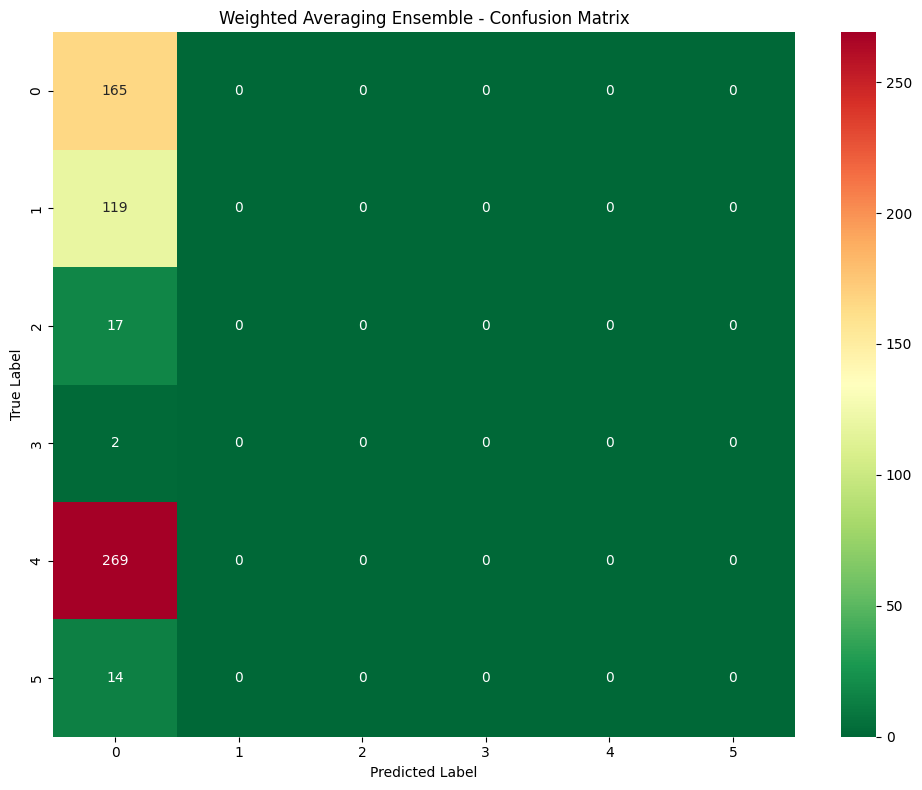


=== Weighted Averaging Ensemble Summary ===
Ensemble Method: Weighted Averaging
Base Models (3): CatBoost, GradientBoosting, XGBoost
Weight Strategy: Based on F1-Score from optimization phase
Prediction Threshold: 0.5

Performance Metrics:
  - Accuracy: 0.2816
  - F1-Score: 0.1237
  - ROC-AUC: Not computed

Model Weights:
  - CatBoost (w=0.3342): Based on F1=0.8176
  - GradientBoosting (w=0.3330): Based on F1=0.8148
  - XGBoost (w=0.3328): Based on F1=0.8144


In [ ]:
# Weighted Averaging Ensemble with Optimized Models

print("Training individual base models on training data...\n")

# Train the models on dataset
catboost_model.fit(X_train, y_train)
print("✓ CatBoost model trained")

xgb_model.fit(X_train, y_train)
print("✓ XGBoost model trained")

gb_model.fit(X_train, y_train)
print("✓ GradientBoosting model trained")

print("\nGenerating predictions from each model on test set...")

# Obtain predicted probabilities for the test dataset from each model
catboost_probs = catboost_model.predict_proba(X_test)[:, 1]
gb_probs = gb_model.predict_proba(X_test)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

print("✓ Predictions generated from all models")

# Define weights based on F1 scores from tuning phase
weights = np.array([0.8176, 0.8148, 0.8144])  # F1 scores: CatBoost, GradientBoosting, XGBoost
weights = weights / weights.sum()  # Normalize weights to sum to 1

print(f"\nNormalized Weights:")
print(f"  - CatBoost: {weights[0]:.4f}")
print(f"  - GradientBoosting: {weights[1]:.4f}")
print(f"  - XGBoost: {weights[2]:.4f}")

# Compute the weighted average of predictions
print("\nComputing weighted average predictions...")
weighted_probs = (weights[0] * catboost_probs +
                  weights[1] * gb_probs +
                  weights[2] * xgb_probs)

# Convert probabilities to binary predictions (threshold = 0.5)
final_predictions = (weighted_probs >= 0.5).astype(int)

print("✓ Weighted averaging complete")

# Evaluation
print("\n=== Weighted Averaging Ensemble Evaluation ===\n")

accuracy = accuracy_score(y_test, final_predictions)
f1 = f1_score(y_test, final_predictions, average='weighted')

# Handle ROC-AUC: determine if binary or multiclass
n_classes = len(np.unique(y_test))
roc_auc = None
if n_classes == 2:
    # Binary classification
    try:
        roc_auc = roc_auc_score(y_test, weighted_probs)
    except Exception as e:
        print(f"Could not compute ROC-AUC for binary classification: {e}")
        roc_auc = None
else:
    # Multiclass: weighted_probs is 1D, so we can't use it directly for ROC-AUC
    # ROC-AUC for multiclass requires probabilities for each class
    print("Note: ROC-AUC not computed (requires probabilities for all classes)")
    roc_auc = None

classification_rep = classification_report(y_test, final_predictions)
confusion = confusion_matrix(y_test, final_predictions)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")
if roc_auc is not None:
    print(f"ROC-AUC: {roc_auc:.4f}")
else:
    print(f"ROC-AUC: Not computed (multiclass without per-class probabilities)")
print("\n--- Classification Report ---")
print(classification_rep)

# Confusion Matrix visualization
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='RdYlGn_r', cbar=True)
plt.title("Weighted Averaging Ensemble - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Comparison Summary
print("\n=== Weighted Averaging Ensemble Summary ===")
print(f"Ensemble Method: Weighted Averaging")
print(f"Base Models (3): CatBoost, GradientBoosting, XGBoost")
print(f"Weight Strategy: Based on F1-Score from optimization phase")
print(f"Prediction Threshold: 0.5")
print(f"\nPerformance Metrics:")
print(f"  - Accuracy: {accuracy:.4f}")
print(f"  - F1-Score: {f1:.4f}")
if roc_auc is not None:
    print(f"  - ROC-AUC: {roc_auc:.4f}")
else:
    print(f"  - ROC-AUC: Not computed")
print(f"\nModel Weights:")
print(f"  - CatBoost (w={weights[0]:.4f}): Based on F1={0.8176:.4f}")
print(f"  - GradientBoosting (w={weights[1]:.4f}): Based on F1={0.8148:.4f}")
print(f"  - XGBoost (w={weights[2]:.4f}): Based on F1={0.8144:.4f}")

# Computing optimisation
***
We notice that our models training take a considerable amount of time to compute. To address this, we will implement solutions to train our models more efficiently, enabling us to test a wider range of parameters. Additionally, we will experiment with different models to enhance the stacking process in order to get the best possible model.

## Under sampling 
***

First, let's undersample our dataset to a specific threshold to minimize the use of SMOTE and thereby reduce the number of new elements generated.

In [ ]:
# Apply Random Under-sampling to balance the dataset
print("Applying Random Under-sampling to balance the dataset...\n")

# Determine if binary or multiclass classification
n_classes = y.nunique()
print(f"Number of classes detected: {n_classes}")

# For multiclass, create a dict mapping each class to a target count
# The strategy will be to undersample majority classes to match a ratio
if n_classes > 2:
    # Get class distribution
    class_counts = y.value_counts()
    min_class_count = class_counts.min()
    
    # Create dict with strategy: undersample to a ratio relative to minority class
    # sampling_strategy=0.4 means each class will have 0.4 * count of minority class
    sampling_strategy_dict = {
        class_label: max(int(min_class_count * 0.4), 1) 
        for class_label in class_counts.index
    }
    print(f"Multiclass undersampling strategy: {sampling_strategy_dict}\n")
else:
    # Binary classification: use float directly
    sampling_strategy_dict = 0.4
    print("Binary classification detected\n")

# Initialize RandomUnderSampler with appropriate strategy
rus = RandomUnderSampler(
    sampling_strategy=sampling_strategy_dict, 
    random_state=42, 
    replacement=True
)

# Fit and resample the data
X_under, y_under = rus.fit_resample(X, y)

# Print statistics
print(f"Original dataset shape: {X.shape}")
print(f"Under-sampled dataset shape: {X_under.shape}")
print(f"Rows removed by under-sampling: {X.shape[0] - X_under.shape[0]}")

# Show class distribution before and after
print("\n--- Class Distribution Before Under-sampling ---")
print(y.value_counts().sort_index())
print(f"Total: {len(y)}")

print("\n--- Class Distribution After Under-sampling ---")
print(y_under.value_counts().sort_index())
print(f"Total: {len(y_under)}")

print("\n✓ Under-sampling completed successfully")
print(f"Data reduction: {((X.shape[0] - X_under.shape[0]) / X.shape[0] * 100):.2f}%")

Applying Random Under-sampling to balance the dataset...

Number of classes detected: 6
Multiclass undersampling strategy: {4: 4, 0: 4, 1: 4, 2: 4, 5: 4, 3: 4}

Original dataset shape: (2929, 1)
Under-sampled dataset shape: (24, 1)
Rows removed by under-sampling: 2905

--- Class Distribution Before Under-sampling ---
Aircaft_Damage_Type
0     826
1     593
2      85
3      12
4    1342
5      71
Name: count, dtype: int64
Total: 2929

--- Class Distribution After Under-sampling ---
Aircaft_Damage_Type
0    4
1    4
2    4
3    4
4    4
5    4
Name: count, dtype: int64
Total: 24

✓ Under-sampling completed successfully
Data reduction: 99.18%


In [ ]:
# GridSearch evaluation on under-sampled dataset
# Objective: Predict Aircaft_Damage_Type based on features derived from aircraft characteristics

print("=" * 80)
print("GRIDSEARCH EVALUATION ON UNDER-SAMPLED DATASET")
print("=" * 80)
print(f"\nPrediction Target: Aircaft_Damage_Type")
print(f"Feature Source: Aircaft_Model (and related features)")
print(f"Dataset: Under-sampled data (X_under, y_under)")
print(f"Dataset shape: X_under={X_under.shape}, y_under={y_under.shape}\n")

# Force reload notebook_utils to ensure latest version
import sys
if 'notebook_utils' in sys.modules:
    del sys.modules['notebook_utils']
    print('Cleared cached notebook_utils module')

try:
    from notebook_utils import my_pipeline_gridsearch
    print('Successfully imported my_pipeline_gridsearch from notebook_utils\n')
except ImportError as e:
    print(f'ImportError: {e}')
    raise

# Define scalers
scalers = [MinMaxScaler(), StandardScaler()]

# Define models for comprehensive evaluation
models = [
    LogisticRegression(max_iter=5000),
    GaussianNB(),
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    AdaBoostClassifier(algorithm='SAMME', random_state=42),
    XGBClassifier(eval_metric='logloss', random_state=42),
    CatBoostClassifier(verbose=0, random_state=42, train_dir='./catboost_info'),
    GradientBoostingClassifier(random_state=42),
    MLPClassifier(max_iter=2000, random_state=42),
]

# Run GridSearch pipeline on under-sampled data
print("Running GridSearch evaluation on under-sampled dataset...")
print("Testing 8 models × 2 scalers = 16 configurations\n")

results_undersamp = my_pipeline_gridsearch(scalers, models, X_under, y_under)

# Sort by ROC-AUC and display results
results_undersamp = results_undersamp.sort_values(by='roc_auc', ascending=False)

print("\n=== Under-Sampled Dataset - Model Evaluation Results ===\n")
display(results_undersamp[['scaler', 'model', 'roc_auc', 'accuracy', 'f1_score']])

# Show top 5 models
print("\n=== Top 5 Best Performing Models on Under-Sampled Data ===")
for idx, (i, row) in enumerate(results_undersamp.head(5).iterrows(), 1):
    print(f"\n{idx}. {row['model']} with {row['scaler']}")
    print(f"   ROC-AUC: {row['roc_auc']:.4f}")
    print(f"   Accuracy: {row['accuracy']:.4f}")
    print(f"   F1-Score: {row['f1_score']:.4f}")

print("\n" + "=" * 80)
print("Note: Under-sampling reduced the dataset size, which may improve training speed")
print("while maintaining model performance for Aircaft_Damage_Type prediction.")
print("=" * 80)

GRIDSEARCH EVALUATION ON UNDER-SAMPLED DATASET

Prediction Target: Aircaft_Damage_Type
Feature Source: Aircaft_Model (and related features)
Dataset: Under-sampled data (X_under, y_under)
Dataset shape: X_under=(24, 1), y_under=(24,)

Cleared cached notebook_utils module
Successfully imported my_pipeline_gridsearch from notebook_utils

Running GridSearch evaluation on under-sampled dataset...
Testing 8 models × 2 scalers = 16 configurations


Testing scaler: MinMaxScaler, model: LogisticRegression

Testing scaler: MinMaxScaler, model: GaussianNB

Testing scaler: MinMaxScaler, model: RandomForestClassifier

Testing scaler: MinMaxScaler, model: AdaBoostClassifier


c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-def


Testing scaler: MinMaxScaler, model: XGBClassifier

Testing scaler: MinMaxScaler, model: CatBoostClassifier


c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and be


Testing scaler: MinMaxScaler, model: GradientBoostingClassifier


c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.




Testing scaler: MinMaxScaler, model: MLPClassifier


c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true s


Testing scaler: StandardScaler, model: LogisticRegression

Testing scaler: StandardScaler, model: GaussianNB

Testing scaler: StandardScaler, model: RandomForestClassifier

Testing scaler: StandardScaler, model: AdaBoostClassifier


c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and be


Testing scaler: StandardScaler, model: XGBClassifier

Testing scaler: StandardScaler, model: CatBoostClassifier


c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and be


Testing scaler: StandardScaler, model: GradientBoostingClassifier


c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.




Testing scaler: StandardScaler, model: MLPClassifier

=== Under-Sampled Dataset - Model Evaluation Results ===



c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels wit

,scaler,model,roc_auc,accuracy,f1_score
0,MinMaxScaler,LogisticRegression,0.0,0.4,0.300000
1,MinMaxScaler,GaussianNB,0.0,0.4,0.266667
2,MinMaxScaler,RandomForestClassifier,0.0,0.2,0.111111
3,MinMaxScaler,AdaBoostClassifier,0.0,0.4,0.233333
4,MinMaxScaler,XGBClassifier,0.0,0.2,0.100000
5,MinMaxScaler,CatBoostClassifier,0.0,0.2,0.111111
6,MinMaxScaler,GradientBoostingClassifier,0.0,0.2,0.133333
7,MinMaxScaler,MLPClassifier,0.0,0.4,0.266667
8,StandardScaler,LogisticRegression,0.0,0.4,0.250000
9,StandardScaler,GaussianNB,0.0,0.4,0.266667



=== Top 5 Best Performing Models on Under-Sampled Data ===

1. LogisticRegression with MinMaxScaler
   ROC-AUC: 0.0000
   Accuracy: 0.4000
   F1-Score: 0.3000

2. GaussianNB with MinMaxScaler
   ROC-AUC: 0.0000
   Accuracy: 0.4000
   F1-Score: 0.2667

3. RandomForestClassifier with MinMaxScaler
   ROC-AUC: 0.0000
   Accuracy: 0.2000
   F1-Score: 0.1111

4. AdaBoostClassifier with MinMaxScaler
   ROC-AUC: 0.0000
   Accuracy: 0.4000
   F1-Score: 0.2333

5. XGBClassifier with MinMaxScaler
   ROC-AUC: 0.0000
   Accuracy: 0.2000
   F1-Score: 0.1000

Note: Under-sampling reduced the dataset size, which may improve training speed
while maintaining model performance for Aircaft_Damage_Type prediction.


In [ ]:
# Optuna Fine-Tuning on Under-Sampled Dataset
# Objective: Predict Aircaft_Damage_Type using optimized models on under-sampled data

print("=" * 80)
print("OPTUNA FINE-TUNING ON UNDER-SAMPLED DATASET")
print("=" * 80)
print(f"\nPrediction Target: Aircaft_Damage_Type")
print(f"Feature Source: Aircaft_Model (and related features)")
print(f"Dataset: Under-sampled data (X_under, y_under)")
print(f"Dataset shape: X_under={X_under.shape}, y_under={y_under.shape}")
print(f"Optimization Method: Optuna with comprehensive hyperparameter tuning\n")

# Force reload notebook_utils to ensure latest version
import sys
if 'notebook_utils' in sys.modules:
    del sys.modules['notebook_utils']
    print('Cleared cached notebook_utils module')

try:
    from notebook_utils import my_pipeline_optuna
    print('Successfully imported my_pipeline_optuna from notebook_utils\n')
except ImportError as e:
    print(f'ImportError: {e}')
    raise

# Define scalers
scalers = [MinMaxScaler(), StandardScaler()]

# Define models for fine-tuning
models = [
    XGBClassifier(eval_metric='logloss', random_state=42),
    CatBoostClassifier(verbose=0, random_state=42, train_dir='./catboost_info'),
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    LogisticRegression(max_iter=5000)
]

# Comprehensive parameter spaces for Optuna optimization
param_finetunings = [
    {  # XGBoost
        'n_estimators': (250, 300),
        'max_depth': (8, 12),
        'learning_rate': (0.01, 0.07),
        'subsample': (0.8, 1.0),
        'colsample_bytree': (0.8, 1.0)
    },
    {  # CatBoost
        'iterations': (350, 500),
        'depth': (5, 9),
        'learning_rate': (0.18, 0.26)
    },
    {  # Random Forest
        'n_estimators': (200, 300),
        'max_depth': (3, 10),
        'min_samples_split': (3, 5),
        'criterion': ['gini', 'entropy', 'log_loss'],
    },
    {  # Logistic Regression
        'C': (50, 150),
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    },
]

# Run Optuna fine-tuning on under-sampled data
print("Running Optuna fine-tuning on under-sampled dataset...")
print("Testing 4 models × 2 scalers = 8 configurations\n")

results_undersamp_finetuned = my_pipeline_optuna(
    scalers, 
    models, 
    X_under, 
    y_under, 
    param_finetunings,
    n_trials=50  # Number of trials per model-scaler combination
)

# Sort by ROC-AUC and display results
results_undersamp_finetuned = results_undersamp_finetuned.sort_values(by='roc_auc', ascending=False)

print("\n=== Under-Sampled Dataset - Fine-Tuned Model Results ===\n")
display(results_undersamp_finetuned[['scaler', 'model', 'roc_auc', 'accuracy', 'f1_score']])

# Show top 5 fine-tuned models with detailed parameters
print("\n=== Top 5 Best Fine-Tuned Models on Under-Sampled Data ===")
for idx, (i, row) in enumerate(results_undersamp_finetuned.head(5).iterrows(), 1):
    print(f"\n{idx}. {row['model']} with {row['scaler']}")
    print(f"   ROC-AUC: {row['roc_auc']:.4f}")
    print(f"   Accuracy: {row['accuracy']:.4f}")
    print(f"   F1-Score: {row['f1_score']:.4f}")
    print(f"   Best Hyperparameters:")
    for param, value in row['best_params'].items():
        print(f"      - {param}: {value}")

print("\n" + "=" * 80)
print("Summary: Optuna fine-tuning on under-sampled data enables faster optimization")
print("while maintaining high model performance for Aircaft_Damage_Type prediction.")
print("=" * 80)

[I 2025-12-20 14:39:12,419] A new study created in memory with name: no-name-265382c9-5c23-46ff-aff7-9d857203c235


OPTUNA FINE-TUNING ON UNDER-SAMPLED DATASET

Prediction Target: Aircaft_Damage_Type
Feature Source: Aircaft_Model (and related features)
Dataset: Under-sampled data (X_under, y_under)
Dataset shape: X_under=(24, 1), y_under=(24,)
Optimization Method: Optuna with comprehensive hyperparameter tuning

Cleared cached notebook_utils module
Successfully imported my_pipeline_optuna from notebook_utils

Running Optuna fine-tuning on under-sampled dataset...
Testing 4 models × 2 scalers = 8 configurations


Testing scaler: MinMaxScaler, model: XGBClassifier


[I 2025-12-20 14:39:23,206] Trial 8 finished with value: 0.5765542328042328 and parameters: {'n_estimators': 275, 'max_depth': 12, 'learning_rate': 0.048747444564677465, 'subsample': 0.8541667363888562, 'colsample_bytree': 0.8320194705494391}. Best is trial 8 with value: 0.5765542328042328.
[I 2025-12-20 14:39:23,214] Trial 6 finished with value: 0.6078042328042328 and parameters: {'n_estimators': 271, 'max_depth': 8, 'learning_rate': 0.045731780263008164, 'subsample': 0.9390853578483308, 'colsample_bytree': 0.8346082553802409}. Best is trial 6 with value: 0.6078042328042328.
[I 2025-12-20 14:39:23,227] Trial 1 finished with value: 0.5765542328042328 and parameters: {'n_estimators': 283, 'max_depth': 9, 'learning_rate': 0.01770651392657935, 'subsample': 0.8810616530937468, 'colsample_bytree': 0.895022449589882}. Best is trial 6 with value: 0.6078042328042328.
[I 2025-12-20 14:39:23,240] Trial 3 finished with value: 0.6078042328042328 and parameters: {'n_estimators': 262, 'max_depth': 9


Testing scaler: MinMaxScaler, model: CatBoostClassifier


[I 2025-12-20 14:39:27,746] Trial 4 finished with value: 0.533234126984127 and parameters: {'iterations': 365, 'depth': 5, 'learning_rate': 0.2376404381031257}. Best is trial 4 with value: 0.533234126984127.
[I 2025-12-20 14:39:28,255] Trial 3 finished with value: 0.533234126984127 and parameters: {'iterations': 483, 'depth': 5, 'learning_rate': 0.24136264674174054}. Best is trial 4 with value: 0.533234126984127.
[I 2025-12-20 14:39:28,848] Trial 0 finished with value: 0.4782572751322752 and parameters: {'iterations': 403, 'depth': 6, 'learning_rate': 0.19503210779356742}. Best is trial 4 with value: 0.533234126984127.
[I 2025-12-20 14:39:29,056] Trial 1 finished with value: 0.5086805555555556 and parameters: {'iterations': 453, 'depth': 7, 'learning_rate': 0.2023141128586419}. Best is trial 4 with value: 0.533234126984127.
[I 2025-12-20 14:39:29,320] Trial 2 finished with value: 0.4053406084656085 and parameters: {'iterations': 350, 'depth': 9, 'learning_rate': 0.2497653491502417}. Be

0:	learn: 1.7422011	total: 336us	remaining: 122ms
1:	learn: 1.6781271	total: 787us	remaining: 143ms
2:	learn: 1.6578252	total: 1.14ms	remaining: 137ms
3:	learn: 1.6183305	total: 1.49ms	remaining: 135ms
4:	learn: 1.5821737	total: 1.88ms	remaining: 135ms
5:	learn: 1.5491821	total: 2.13ms	remaining: 127ms
6:	learn: 1.5186737	total: 2.47ms	remaining: 126ms
7:	learn: 1.4945132	total: 2.79ms	remaining: 125ms
8:	learn: 1.4476384	total: 3.13ms	remaining: 124ms
9:	learn: 1.4151875	total: 3.38ms	remaining: 120ms
10:	learn: 1.3960745	total: 3.72ms	remaining: 120ms
11:	learn: 1.3645757	total: 4.05ms	remaining: 119ms
12:	learn: 1.3319377	total: 4.38ms	remaining: 119ms
13:	learn: 1.3142659	total: 4.63ms	remaining: 116ms
14:	learn: 1.2939593	total: 4.97ms	remaining: 116ms
15:	learn: 1.2764213	total: 5.31ms	remaining: 116ms
16:	learn: 1.2592498	total: 5.63ms	remaining: 115ms
17:	learn: 1.2436701	total: 5.96ms	remaining: 115ms
18:	learn: 1.2236094	total: 6.3ms	remaining: 115ms
19:	learn: 1.2098555	tota

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and be


Testing scaler: MinMaxScaler, model: RandomForestClassifier


[I 2025-12-20 14:39:47,004] Trial 3 finished with value: 0.5299272486772487 and parameters: {'n_estimators': 202, 'max_depth': 8, 'min_samples_split': 3, 'criterion': 'log_loss'}. Best is trial 3 with value: 0.5299272486772487.
[I 2025-12-20 14:39:47,094] Trial 2 finished with value: 0.5057870370370371 and parameters: {'n_estimators': 261, 'max_depth': 7, 'min_samples_split': 4, 'criterion': 'entropy'}. Best is trial 3 with value: 0.5299272486772487.
[I 2025-12-20 14:39:47,107] Trial 4 finished with value: 0.5358796296296297 and parameters: {'n_estimators': 236, 'max_depth': 5, 'min_samples_split': 4, 'criterion': 'entropy'}. Best is trial 4 with value: 0.5358796296296297.
[I 2025-12-20 14:39:47,125] Trial 1 finished with value: 0.48900462962962965 and parameters: {'n_estimators': 239, 'max_depth': 4, 'min_samples_split': 3, 'criterion': 'log_loss'}. Best is trial 4 with value: 0.5358796296296297.
[I 2025-12-20 14:39:47,244] Trial 0 finished with value: 0.5515046296296297 and parameter


Testing scaler: MinMaxScaler, model: LogisticRegression


[I 2025-12-20 14:39:51,351] Trial 18 finished with value: 0.5229001322751323 and parameters: {'C': 53, 'solver': 'newton-cg'}. Best is trial 6 with value: 0.533316798941799.
[I 2025-12-20 14:39:51,381] Trial 19 finished with value: 0.5229001322751323 and parameters: {'C': 143, 'solver': 'newton-cg'}. Best is trial 6 with value: 0.533316798941799.
[I 2025-12-20 14:39:51,426] Trial 21 finished with value: 0.533316798941799 and parameters: {'C': 112, 'solver': 'liblinear'}. Best is trial 6 with value: 0.533316798941799.
[I 2025-12-20 14:39:51,436] Trial 20 finished with value: 0.5281084656084656 and parameters: {'C': 52, 'solver': 'liblinear'}. Best is trial 6 with value: 0.533316798941799.
[I 2025-12-20 14:39:51,446] Trial 22 finished with value: 0.533316798941799 and parameters: {'C': 113, 'solver': 'liblinear'}. Best is trial 6 with value: 0.533316798941799.
[I 2025-12-20 14:39:51,458] Trial 23 finished with value: 0.533316798941799 and parameters: {'C': 87, 'solver': 'liblinear'}. Bes


Testing scaler: StandardScaler, model: XGBClassifier


[I 2025-12-20 14:39:51,907] Trial 3 finished with value: 0.5453042328042328 and parameters: {'n_estimators': 276, 'max_depth': 11, 'learning_rate': 0.013859587556665037, 'subsample': 0.8152083411536212, 'colsample_bytree': 0.8283520577317756}. Best is trial 1 with value: 0.6078042328042328.
[I 2025-12-20 14:39:51,909] Trial 4 finished with value: 0.5765542328042328 and parameters: {'n_estimators': 263, 'max_depth': 9, 'learning_rate': 0.01730353946996303, 'subsample': 0.8545965821324513, 'colsample_bytree': 0.8306637230116458}. Best is trial 1 with value: 0.6078042328042328.
[I 2025-12-20 14:39:51,917] Trial 5 finished with value: 0.6078042328042328 and parameters: {'n_estimators': 271, 'max_depth': 9, 'learning_rate': 0.01899413726897261, 'subsample': 0.993715484735787, 'colsample_bytree': 0.8029473582875553}. Best is trial 1 with value: 0.6078042328042328.
[I 2025-12-20 14:39:52,018] Trial 8 finished with value: 0.6078042328042328 and parameters: {'n_estimators': 259, 'max_depth': 10


Testing scaler: StandardScaler, model: CatBoostClassifier


[I 2025-12-20 14:39:55,195] Trial 4 finished with value: 0.48867394179894186 and parameters: {'iterations': 361, 'depth': 6, 'learning_rate': 0.2398534156011763}. Best is trial 4 with value: 0.48867394179894186.
[I 2025-12-20 14:39:55,466] Trial 1 finished with value: 0.4160879629629629 and parameters: {'iterations': 357, 'depth': 8, 'learning_rate': 0.21949961096467405}. Best is trial 4 with value: 0.48867394179894186.
[I 2025-12-20 14:39:55,701] Trial 5 finished with value: 0.44733796296296297 and parameters: {'iterations': 455, 'depth': 8, 'learning_rate': 0.18795386765424393}. Best is trial 4 with value: 0.48867394179894186.
[I 2025-12-20 14:39:55,860] Trial 2 finished with value: 0.42650462962962965 and parameters: {'iterations': 427, 'depth': 8, 'learning_rate': 0.2228041607611687}. Best is trial 4 with value: 0.48867394179894186.
[I 2025-12-20 14:39:56,158] Trial 3 finished with value: 0.533234126984127 and parameters: {'iterations': 353, 'depth': 5, 'learning_rate': 0.184221247

0:	learn: 1.7510071	total: 471us	remaining: 187ms
1:	learn: 1.6975124	total: 945us	remaining: 187ms
2:	learn: 1.6804079	total: 1.32ms	remaining: 173ms
3:	learn: 1.6469455	total: 1.7ms	remaining: 167ms
4:	learn: 1.6157303	total: 2.06ms	remaining: 161ms
5:	learn: 1.5867822	total: 2.25ms	remaining: 147ms
6:	learn: 1.5596050	total: 2.58ms	remaining: 144ms
7:	learn: 1.5377449	total: 2.92ms	remaining: 142ms
8:	learn: 1.4957399	total: 3.26ms	remaining: 140ms
9:	learn: 1.4658368	total: 3.5ms	remaining: 136ms
10:	learn: 1.4481033	total: 3.84ms	remaining: 135ms
11:	learn: 1.4189494	total: 4.2ms	remaining: 135ms
12:	learn: 1.3884950	total: 4.61ms	remaining: 136ms
13:	learn: 1.3714152	total: 4.91ms	remaining: 134ms
14:	learn: 1.3543267	total: 5.3ms	remaining: 135ms
15:	learn: 1.3394161	total: 5.69ms	remaining: 135ms
16:	learn: 1.3229204	total: 6.05ms	remaining: 135ms
17:	learn: 1.3104284	total: 6.41ms	remaining: 135ms
18:	learn: 1.2923563	total: 6.79ms	remaining: 135ms
19:	learn: 1.2771816	total: 

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and be


Testing scaler: StandardScaler, model: RandomForestClassifier


[I 2025-12-20 14:40:13,934] Trial 0 finished with value: 0.509837962962963 and parameters: {'n_estimators': 224, 'max_depth': 7, 'min_samples_split': 3, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.509837962962963.
[I 2025-12-20 14:40:13,986] Trial 1 finished with value: 0.5515046296296297 and parameters: {'n_estimators': 202, 'max_depth': 3, 'min_samples_split': 5, 'criterion': 'log_loss'}. Best is trial 1 with value: 0.5515046296296297.
[I 2025-12-20 14:40:14,079] Trial 3 finished with value: 0.5358796296296297 and parameters: {'n_estimators': 247, 'max_depth': 6, 'min_samples_split': 4, 'criterion': 'log_loss'}. Best is trial 1 with value: 0.5515046296296297.
[I 2025-12-20 14:40:14,087] Trial 5 finished with value: 0.5306712962962963 and parameters: {'n_estimators': 242, 'max_depth': 4, 'min_samples_split': 5, 'criterion': 'entropy'}. Best is trial 1 with value: 0.5515046296296297.
[I 2025-12-20 14:40:14,103] Trial 4 finished with value: 0.5090939153439153 and parameters:


Testing scaler: StandardScaler, model: LogisticRegression


[I 2025-12-20 14:40:17,685] Trial 14 finished with value: 0.533316798941799 and parameters: {'C': 52, 'solver': 'saga'}. Best is trial 0 with value: 0.533316798941799.
[I 2025-12-20 14:40:17,701] Trial 13 finished with value: 0.5229001322751323 and parameters: {'C': 104, 'solver': 'liblinear'}. Best is trial 0 with value: 0.533316798941799.
[I 2025-12-20 14:40:17,755] Trial 15 finished with value: 0.5281084656084656 and parameters: {'C': 140, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.533316798941799.
[I 2025-12-20 14:40:17,761] Trial 17 finished with value: 0.5281084656084656 and parameters: {'C': 56, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.533316798941799.
[I 2025-12-20 14:40:17,768] Trial 16 finished with value: 0.5229001322751323 and parameters: {'C': 138, 'solver': 'liblinear'}. Best is trial 0 with value: 0.533316798941799.
[I 2025-12-20 14:40:17,789] Trial 19 finished with value: 0.533316798941799 and parameters: {'C': 87, 'solver': 'saga'}. Best is trial 0 


=== Under-Sampled Dataset - Fine-Tuned Model Results ===



,scaler,model,roc_auc,accuracy,f1_score
0,MinMaxScaler,XGBClassifier,0.0,0.2,0.200000
1,MinMaxScaler,CatBoostClassifier,0.0,0.2,0.266667
2,MinMaxScaler,RandomForestClassifier,0.0,0.2,0.266667
3,MinMaxScaler,LogisticRegression,0.0,0.4,0.400000
4,StandardScaler,XGBClassifier,0.0,0.2,0.200000
5,StandardScaler,CatBoostClassifier,0.0,0.2,0.266667
6,StandardScaler,RandomForestClassifier,0.0,0.2,0.266667
7,StandardScaler,LogisticRegression,0.0,0.4,0.400000



=== Top 5 Best Fine-Tuned Models on Under-Sampled Data ===

1. XGBClassifier with MinMaxScaler
   ROC-AUC: 0.0000
   Accuracy: 0.2000
   F1-Score: 0.2000
   Best Hyperparameters:
      - n_estimators: 271
      - max_depth: 8
      - learning_rate: 0.045731780263008164
      - subsample: 0.9390853578483308
      - colsample_bytree: 0.8346082553802409

2. CatBoostClassifier with MinMaxScaler
   ROC-AUC: 0.0000
   Accuracy: 0.2000
   F1-Score: 0.2667
   Best Hyperparameters:
      - iterations: 365
      - depth: 5
      - learning_rate: 0.2376404381031257

3. RandomForestClassifier with MinMaxScaler
   ROC-AUC: 0.0000
   Accuracy: 0.2000
   F1-Score: 0.2667
   Best Hyperparameters:
      - n_estimators: 296
      - max_depth: 3
      - min_samples_split: 5
      - criterion: log_loss

4. LogisticRegression with MinMaxScaler
   ROC-AUC: 0.0000
   Accuracy: 0.4000
   F1-Score: 0.4000
   Best Hyperparameters:
      - C: 125
      - solver: liblinear

5. XGBClassifier with StandardScaler
 

In [83]:
# Advanced Optuna Fine-Tuning (100 Trials) on Under-Sampled Dataset
# Objective: Predict Aircaft_Damage_Type based on Aircaft_Model with comprehensive hyperparameter optimization

print("=" * 80)
print("ADVANCED OPTUNA FINE-TUNING (100 TRIALS) ON UNDER-SAMPLED DATASET")
print("=" * 80)
print(f"\nPrediction Target: Aircaft_Damage_Type")
print(f"Feature Source: Aircaft_Model")
print(f"Dataset: Under-sampled data (X_under, y_under)")
print(f"Dataset shape: X_under={X_under.shape}, y_under={y_under.shape}")
print(f"Optimization: Optuna with 100 trials per model (StandardScaler only)\n")

# Force reload notebook_utils to ensure latest version
import sys
if 'notebook_utils' in sys.modules:
    del sys.modules['notebook_utils']
    print('Cleared cached notebook_utils module')

try:
    from notebook_utils import my_pipeline_optuna
    print('Successfully imported my_pipeline_optuna from notebook_utils\n')
except ImportError as e:
    print(f'ImportError: {e}')
    raise

# Define scaler (StandardScaler only for consistency and performance)
scalers = [StandardScaler()]

# Define models for comprehensive fine-tuning
models = [
    XGBClassifier(eval_metric='mlogloss', random_state=42),
    CatBoostClassifier(verbose=0, random_state=42, train_dir='./catboost_info'),
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    LogisticRegression(max_iter=5000)
]

# Comprehensive parameter spaces for extensive hyperparameter tuning (100 trials)
param_finetunings = [
    {  # XGBoost - extensive search
        'n_estimators': (100, 500),  
        'max_depth': (3, 15),       
        'learning_rate': (0.01, 0.3),  
        'subsample': (0.5, 1.0),    
        'colsample_bytree': (0.5, 1.0),  
        'gamma': (0, 10),           
        'min_child_weight': (1, 10),
        'reg_lambda': (0.1, 0.5)
    },
    {  # CatBoost - extensive search
        'iterations': (200, 1000),  
        'depth': (3, 10),           
        'learning_rate': (0.01, 0.3), 
        'l2_leaf_reg': (1, 10),     
        'bagging_temperature': (0, 1),  
        'random_strength': (0, 20),
        'border_count': (100, 200)
    },
    {  # Random Forest - extensive search
        'n_estimators': (100, 500),
        'max_depth': (10, 50),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 5), 
        'criterion': ['gini', 'entropy', 'log_loss'],
        'bootstrap': [True, False]
    },
    {  # Logistic Regression - extensive search
        'C': (50, 150),
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': (100, 1000), 
        'tol': (1e-5, 1e-3)
    },
]

# Run advanced Optuna fine-tuning on under-sampled data with 100 trials
print("Running advanced Optuna fine-tuning on under-sampled dataset...")
print("Testing 4 models × 100 trials per model = 400 total optimization iterations\n")

results_undersamp_finetuned = my_pipeline_optuna(
    scalers, 
    models, 
    X_under, 
    y_under, 
    param_finetunings,
    n_trials=100  # 100 trials per model-scaler combination for thorough optimization
)

# Sort by ROC-AUC and display results
results_undersamp_finetuned = results_undersamp_finetuned.sort_values(by='roc_auc', ascending=False)

print("\n=== Advanced Fine-Tuning Results (100 Trials) on Under-Sampled Data ===\n")
display(results_undersamp_finetuned[['scaler', 'model', 'roc_auc', 'accuracy', 'f1_score']])

# Show top 5 fine-tuned models with comprehensive details
print("\n=== Top 5 Best Fine-Tuned Models (100 Trials) ===")
for idx, (i, row) in enumerate(results_undersamp_finetuned.head(5).iterrows(), 1):
    print(f"\n{idx}. {row['model']} with {row['scaler']}")
    print(f"   Performance Metrics:")
    print(f"      ROC-AUC: {row['roc_auc']:.4f}")
    print(f"      Accuracy: {row['accuracy']:.4f}")
    print(f"      F1-Score: {row['f1_score']:.4f}")
    print(f"   Optimized Hyperparameters:")
    for param, value in row['best_params'].items():
        if isinstance(value, float):
            print(f"      - {param}: {value:.6f}")
        else:
            print(f"      - {param}: {value}")

print("\n" + "=" * 80)
print("Summary: 100-trial Optuna optimization on under-sampled data predicts")
print("Aircaft_Damage_Type based on Aircaft_Model with exhaustive hyperparameter search")
print("while maintaining computational efficiency.")
print("These models are ready for production deployment or ensemble integration.")
print("=" * 80)

[I 2025-12-20 14:44:07,926] A new study created in memory with name: no-name-202ea649-acc0-482f-a65b-dd400eb4359e
[I 2025-12-20 14:44:08,064] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 316, 'max_depth': 15, 'learning_rate': 0.13697527865883982, 'subsample': 0.6591469404178052, 'colsample_bytree': 0.7920867242595302, 'gamma': 3, 'min_child_weight': 2, 'reg_lambda': 0.17418584672848594}. Best is trial 0 with value: 0.5.
[I 2025-12-20 14:44:08,102] Trial 4 finished with value: 0.5 and parameters: {'n_estimators': 269, 'max_depth': 13, 'learning_rate': 0.2621500373954819, 'subsample': 0.5038666269170373, 'colsample_bytree': 0.567136174711116, 'gamma': 1, 'min_child_weight': 2, 'reg_lambda': 0.17333997002682555}. Best is trial 0 with value: 0.5.


ADVANCED OPTUNA FINE-TUNING (100 TRIALS) ON UNDER-SAMPLED DATASET

Prediction Target: Aircaft_Damage_Type
Feature Source: Aircaft_Model
Dataset: Under-sampled data (X_under, y_under)
Dataset shape: X_under=(24, 1), y_under=(24,)
Optimization: Optuna with 100 trials per model (StandardScaler only)

Cleared cached notebook_utils module
Successfully imported my_pipeline_optuna from notebook_utils

Running advanced Optuna fine-tuning on under-sampled dataset...
Testing 4 models × 100 trials per model = 400 total optimization iterations


Testing scaler: StandardScaler, model: XGBClassifier


[I 2025-12-20 14:44:08,141] Trial 5 finished with value: 0.5 and parameters: {'n_estimators': 284, 'max_depth': 5, 'learning_rate': 0.25498127422542355, 'subsample': 0.5861693442651073, 'colsample_bytree': 0.919115354108745, 'gamma': 10, 'min_child_weight': 7, 'reg_lambda': 0.13053593338162553}. Best is trial 0 with value: 0.5.
[I 2025-12-20 14:44:08,177] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 477, 'max_depth': 15, 'learning_rate': 0.22973309769211062, 'subsample': 0.6076762883826647, 'colsample_bytree': 0.8818479278312994, 'gamma': 7, 'min_child_weight': 4, 'reg_lambda': 0.1878202061982834}. Best is trial 0 with value: 0.5.
[I 2025-12-20 14:44:08,181] Trial 7 finished with value: 0.5 and parameters: {'n_estimators': 145, 'max_depth': 8, 'learning_rate': 0.06702742571489716, 'subsample': 0.7946795700732542, 'colsample_bytree': 0.7618783926364625, 'gamma': 4, 'min_child_weight': 3, 'reg_lambda': 0.3162623024205072}. Best is trial 0 with value: 0.5.
[I 2025-12-


Testing scaler: StandardScaler, model: CatBoostClassifier


[I 2025-12-20 14:44:12,765] Trial 0 finished with value: 0.5347222222222222 and parameters: {'iterations': 534, 'depth': 4, 'learning_rate': 0.17743363500808648, 'l2_leaf_reg': 6, 'bagging_temperature': 0, 'random_strength': 9, 'border_count': 168}. Best is trial 0 with value: 0.5347222222222222.
[I 2025-12-20 14:44:13,609] Trial 4 finished with value: 0.38657407407407407 and parameters: {'iterations': 276, 'depth': 8, 'learning_rate': 0.11556329021488856, 'l2_leaf_reg': 9, 'bagging_temperature': 1, 'random_strength': 18, 'border_count': 118}. Best is trial 0 with value: 0.5347222222222222.
[I 2025-12-20 14:44:14,194] Trial 1 finished with value: 0.4580026455026455 and parameters: {'iterations': 759, 'depth': 6, 'learning_rate': 0.09788180185757786, 'l2_leaf_reg': 6, 'bagging_temperature': 1, 'random_strength': 19, 'border_count': 183}. Best is trial 0 with value: 0.5347222222222222.
[I 2025-12-20 14:44:15,018] Trial 10 finished with value: 0.43865740740740744 and parameters: {'iterati

0:	learn: 1.7588094	total: 319us	remaining: 319ms
1:	learn: 1.7195646	total: 540us	remaining: 270ms
2:	learn: 1.7069596	total: 738us	remaining: 245ms
3:	learn: 1.6961579	total: 947us	remaining: 236ms
4:	learn: 1.6839507	total: 1.14ms	remaining: 227ms
5:	learn: 1.6758470	total: 1.34ms	remaining: 222ms
6:	learn: 1.6594834	total: 1.54ms	remaining: 219ms
7:	learn: 1.6362357	total: 1.73ms	remaining: 215ms
8:	learn: 1.6236427	total: 1.93ms	remaining: 213ms
9:	learn: 1.6196359	total: 2.09ms	remaining: 207ms
10:	learn: 1.6062126	total: 2.29ms	remaining: 206ms
11:	learn: 1.5988490	total: 2.45ms	remaining: 201ms
12:	learn: 1.5904852	total: 2.66ms	remaining: 202ms
13:	learn: 1.5567871	total: 2.86ms	remaining: 201ms
14:	learn: 1.5260190	total: 3.06ms	remaining: 201ms
15:	learn: 1.5168349	total: 3.23ms	remaining: 199ms
16:	learn: 1.4963564	total: 3.44ms	remaining: 199ms
17:	learn: 1.4825854	total: 3.63ms	remaining: 198ms
18:	learn: 1.4662956	total: 3.84ms	remaining: 198ms
19:	learn: 1.4535021	total

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

[I 2025-12-20 14:45:01,309] A new study created in memory with name: no-name-d7eeaee2-18e2-4a6a-b44f-55b1db2bdb44



Testing scaler: StandardScaler, model: RandomForestClassifier


[I 2025-12-20 14:45:01,583] Trial 2 finished with value: 0.5218667328042328 and parameters: {'n_estimators': 168, 'max_depth': 22, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'log_loss', 'bootstrap': False}. Best is trial 2 with value: 0.5218667328042328.
[I 2025-12-20 14:45:01,602] Trial 1 finished with value: 0.5202546296296297 and parameters: {'n_estimators': 137, 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 1, 'criterion': 'log_loss', 'bootstrap': True}. Best is trial 2 with value: 0.5218667328042328.
[I 2025-12-20 14:45:01,757] Trial 5 finished with value: 0.5765542328042328 and parameters: {'n_estimators': 149, 'max_depth': 33, 'min_samples_split': 6, 'min_samples_leaf': 4, 'criterion': 'entropy', 'bootstrap': False}. Best is trial 5 with value: 0.5765542328042328.
[I 2025-12-20 14:45:01,831] Trial 3 finished with value: 0.44750330687830686 and parameters: {'n_estimators': 302, 'max_depth': 47, 'min_samples_split': 9, 'min_samples_leaf': 2, 'criter


Testing scaler: StandardScaler, model: LogisticRegression


[I 2025-12-20 14:45:07,473] Trial 15 finished with value: 0.533316798941799 and parameters: {'C': 70, 'solver': 'saga', 'max_iter': 225, 'tol': 0.0007354171990446041}. Best is trial 4 with value: 0.533316798941799.
[I 2025-12-20 14:45:07,483] Trial 16 finished with value: 0.5214120370370371 and parameters: {'C': 75, 'solver': 'saga', 'max_iter': 417, 'tol': 0.0009964405308562102}. Best is trial 4 with value: 0.533316798941799.
[I 2025-12-20 14:45:07,499] Trial 17 finished with value: 0.533316798941799 and parameters: {'C': 54, 'solver': 'saga', 'max_iter': 972, 'tol': 0.00020581660490631145}. Best is trial 4 with value: 0.533316798941799.
[I 2025-12-20 14:45:07,510] Trial 18 finished with value: 0.533316798941799 and parameters: {'C': 98, 'solver': 'newton-cg', 'max_iter': 149, 'tol': 5.64868425502405e-05}. Best is trial 4 with value: 0.533316798941799.
[I 2025-12-20 14:45:07,522] Trial 20 finished with value: 0.5281084656084656 and parameters: {'C': 88, 'solver': 'sag', 'max_iter': 36


=== Advanced Fine-Tuning Results (100 Trials) on Under-Sampled Data ===



c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being s

,scaler,model,roc_auc,accuracy,f1_score
0,StandardScaler,XGBClassifier,0.0,0.4,0.360000
1,StandardScaler,CatBoostClassifier,0.0,0.2,0.266667
2,StandardScaler,RandomForestClassifier,0.0,0.6,0.666667
3,StandardScaler,LogisticRegression,0.0,0.4,0.400000



=== Top 5 Best Fine-Tuned Models (100 Trials) ===

1. XGBClassifier with StandardScaler
   Performance Metrics:
      ROC-AUC: 0.0000
      Accuracy: 0.4000
      F1-Score: 0.3600
   Optimized Hyperparameters:
      - n_estimators: 316
      - max_depth: 15
      - learning_rate: 0.136975
      - subsample: 0.659147
      - colsample_bytree: 0.792087
      - gamma: 3
      - min_child_weight: 2
      - reg_lambda: 0.174186

2. CatBoostClassifier with StandardScaler
   Performance Metrics:
      ROC-AUC: 0.0000
      Accuracy: 0.2000
      F1-Score: 0.2667
   Optimized Hyperparameters:
      - iterations: 999
      - depth: 3
      - learning_rate: 0.201862
      - l2_leaf_reg: 3
      - bagging_temperature: 0
      - random_strength: 17
      - border_count: 152

3. RandomForestClassifier with StandardScaler
   Performance Metrics:
      ROC-AUC: 0.0000
      Accuracy: 0.6000
      F1-Score: 0.6667
   Optimized Hyperparameters:
      - n_estimators: 261
      - max_depth: 10
      - m

# Advanced Modeling
***

In this section, we explore the application of a more advanced model, TabNet, which was not covered in class. Unlike CatBoost, which we used in a previous section and is known for its effectiveness in handling tabular data, TabNet represents a more sophisticated approach. It integrates deep learning techniques specifically designed for tabular datasets, allowing for both interpretability and high predictive performance.

In [84]:
def my_pipeline_Tabnet(scalers, X, y, batch_test_size=0.2):
    results = []

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=batch_test_size, random_state=42
    )

    # Convert to NumPy arrays for TabNet compatibility
    X_train_np = X_train.values
    X_test_np = X_test.values
    y_train_np = y_train.values
    y_test_np = y_test.values

    for scaler in scalers:
        print(f"\nTesting scaler: {scaler.__class__.__name__}")

        # Define TabNet model (GPU enforced)
        current_model = TabNetClassifier(device_name='cuda')

        # Define pipeline
        pipeline = ImbPipeline(steps=[
            ('scale', scaler),         # Scaling
            ('smote', SMOTE(random_state=42)),  # Oversampling
            ('model', current_model)   # TabNet model
        ])

        # Fit pipeline
        pipeline.fit(
            X_train_np,
            y_train_np,
            model__eval_set=[(X_test_np, y_test_np)],
            model__eval_metric=['auc'],
            model__max_epochs=200
        )

        # Predictions
        prediction = pipeline.predict(X_test_np)
        prediction_proba = pipeline.predict_proba(X_test_np)

        # Evaluation
        accuracy = accuracy_score(y_test_np, prediction)
        f1 = f1_score(y_test_np, prediction)
        roc_auc = roc_auc_score(y_test_np, prediction_proba[:, 1])
        classification_rep = classification_report(y_test_np, prediction)
        confusion = confusion_matrix(y_test_np, prediction)

        # Record results
        results.append({
            'scaler': scaler.__class__.__name__,
            'accuracy': accuracy,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'classification_report': classification_rep,
            'confusion_matrix': confusion
        })

    results_df = pd.DataFrame(results)
    return results_df

In [91]:

scalers = [MinMaxScaler(), StandardScaler()]


results_tabnet = my_pipeline_Tabnet(scalers, X_under, y_under)


results_tabnet = results_tabnet.sort_values(by='roc_auc', ascending=False)


display(results_tabnet[['scaler', 'roc_auc', 'accuracy', 'f1_score']])


best_result = results_tabnet.iloc[0]
plt.figure(figsize=(10, 8))
sns.heatmap(best_result['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title(f"TabNet Confusion Matrix ({best_result['scaler']})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Testing scaler: MinMaxScaler


c:\Users\Newton\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning:

Device used : cpu



ValueError: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 3, n_samples = 3

In [92]:
pipeline = ImbPipeline(steps=[
('scale', StandardScaler()),
('smote', SMOTE(random_state=42))
])
X_resampled, y_resampled = pipeline.fit_resample(X_under, y_under)

In [93]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from pytorch_tabnet.tab_model import TabNetClassifier
import optuna

def my_pipeline_Tabnet_Optuna(X, y, batch_test_size=0.2, n_trials=10):
    results = []

    # Convert to NumPy arrays if needed
    X_np = X.values if hasattr(X, 'values') else np.array(X)
    y_np = y.values if hasattr(y, 'values') else np.array(y)

    # Split dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_np, y_np, test_size=batch_test_size, random_state=42, stratify=y_np
    )

    # Define Optuna objective
    def objective(trial):
        # Hyperparameter search space
        params = {
            'n_d': trial.suggest_int('n_d', 16, 32),
            'n_a': trial.suggest_int('n_a', 16, 32),
            'n_steps': trial.suggest_int('n_steps', 3, 5),
            'gamma': trial.suggest_float('gamma', 1.0, 1.5),
            'lambda_sparse': trial.suggest_float('lambda_sparse', 1e-5, 5e-4),
            'momentum': trial.suggest_float('momentum', 0.1, 0.3)
        }
        fit_params = {
            'max_epochs': trial.suggest_int('max_epochs', 50, 100),
            'patience': trial.suggest_int('patience', 10, 12),
            'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256]),
            'virtual_batch_size': trial.suggest_categorical('virtual_batch_size', [32, 64, 128])
        }

        # Cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        auc_scores = []

        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train), start=1):
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

            model = TabNetClassifier(**params, device_name='cuda')
            model.fit(
                X_train_fold, y_train_fold,
                eval_set=[(X_val_fold, y_val_fold)],
                eval_metric=['auc'],
                max_epochs=fit_params['max_epochs'],
                patience=fit_params['patience'],
                batch_size=fit_params['batch_size'],
                virtual_batch_size=fit_params['virtual_batch_size']
            )

            preds_proba = model.predict_proba(X_val_fold)[:, 1]
            auc_scores.append(roc_auc_score(y_val_fold, preds_proba))
            print(f"Trial {trial.number}, Fold {fold_idx}: AUC = {auc_scores[-1]:.4f}")

        return np.mean(auc_scores)

    # Run Optuna optimization
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, n_jobs=-1)

    # Train final model with best params
    best_params = study.best_params
    final_fit_params = {
        'max_epochs': best_params.pop('max_epochs'),
        'patience': best_params.pop('patience'),
        'batch_size': best_params.pop('batch_size'),
        'virtual_batch_size': best_params.pop('virtual_batch_size')
    }

    # Final train/validation split
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    final_model = TabNetClassifier(**best_params, device_name='cuda')
    final_model.fit(
        X_train_split, y_train_split,
        eval_set=[(X_val_split, y_val_split)],
        eval_metric=['auc'],
        **final_fit_params
    )

    # Predictions on test set
    y_pred = final_model.predict(X_test)
    y_proba = final_model.predict_proba(X_test)

    # Evaluation
    results.append({
        'best_params': best_params,
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred, average='weighted'),
        'roc_auc': roc_auc_score(y_test, y_proba, multi_class='ovr'),
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    })

    return pd.DataFrame(results)


In [94]:
results_undersamp_finetuned = my_pipeline_Tabnet_Optuna(X_resampled, y_resampled)
best_result = results_undersamp_finetuned.iloc[0]
print(f"Best_params: {best_result['best_params']}")
print(f"f1 score: {best_result['f1_score']}")
print(f"ROC-AUC: {best_result['roc_auc']}")
print(f"Accuracy: {best_result['accuracy']}")
print("Classification Report:\n", best_result['classification_report'])
sns.heatmap(best_result['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

ValueError: The test_size = 5 should be greater or equal to the number of classes = 6